<a href="https://colab.research.google.com/github/fbudimannn/ADVANCED_RAG/blob/main/Advanced_RAG_for_Medicine_in_Cardiovascular_disease_(CVD)%2C_including_stroke_and_diabetes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Advanced RAG for Medicine in Cardiovascular disease (CVD), including stroke and diabetes
(Muhammad Fakhri Musyaffa Budiman/2288140)**

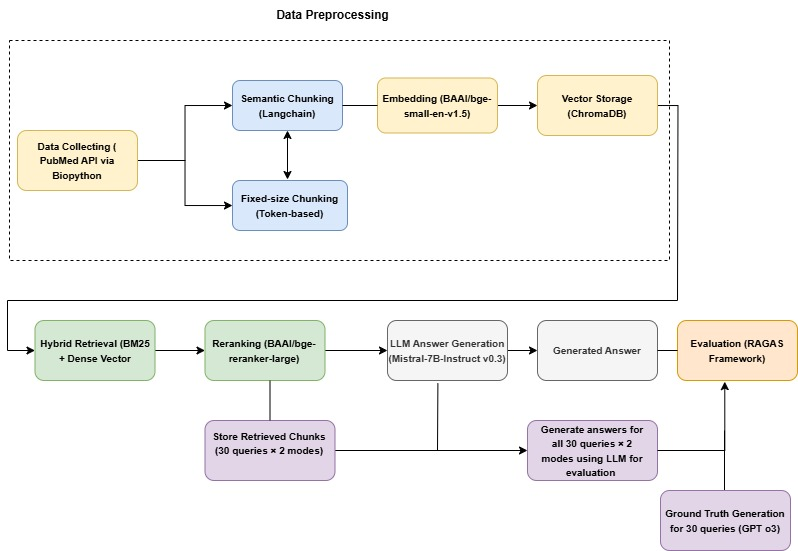

# Data  Collection and Preprocessing

In [ ]:
#run once for installing the libraries
!pip install langchain langchain-huggingface langchain-experimental
!pip install transformers sentence-transformers biopython  chromadb rank_bm25 spacy tqdm python-dotenv ragas
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

^C


In [ ]:
#Device check
import torch
torch.cuda.is_available()

True

In [ ]:
import pandas as pd  # For handling tabular data
import numpy as np  # For numerical operations
import seaborn as sns  # For data visualization (statistical graphics)
import matplotlib.pyplot as plt  # For general plotting
from datetime import datetime, timedelta  # For handling date and time
from tqdm import tqdm  # For showing progress bars in loops
from tqdm.auto import tqdm  # For notebook-compatible progress bars (auto selects best interface)

## Scraping ( Data Collecting)

In [ ]:
import json                          # For potential future use (e.g., saving intermediate output as JSON)
from Bio import Entrez               # NCBI PubMed API
import time                          # Used for polite delays between API requests
from urllib.error import HTTPError  # To handle request errors from Entrez

In [ ]:
# ============================================
# 📘 PUBMED SCRAPER with SUBDOMAIN KEYWORDS
# ============================================
# This script searches and extracts biomedical articles from PubMed, which is adapted and modified from https://github.com/TLDWTutorials/PubmedAPI/tree/main
# Each subdomain includes emerging and common clinical keywords relevant to 2023–2025.

# === CONFIGURE ENTREZ ===
Entrez.email = 'fahribudiman1721@gmail.com'         # Required by Entrez when trying to use the library
Entrez.sleep_between_tries = 2                       # Delay between retries if request fails.

# === SUBDOMAIN TOPICS ===
# These keywords were selected because they are emerging medical research areas  such as new drugs, AI gadgets ,and evergreen clinic issues (blood-thinners, rehab).
# Example: "GLP-1 agonist" helps manage diabetes and heart failure;
# -------------------------------------------------------------------------------------------------
#  Keyword list grouped in 10 mini-categories so retrieval prompts can be conditioned,
#   That makes it easier to craft **diverse test queries**
# -------------------------------------------------------------------------------------------------
subdomain_topic_map = {
    "Cardiovascular (CVD), incl. stroke & diabetes": [

        # 1️⃣ Modern drugs / incretins--------“New” medicine for heart & diabetes that highly cited RCTs 2023-2025 on metabolic HF therapy
        "GLP-1 agonist heart failure",        # Semaglutide shown to ↓ CV events + weight in HF patients ( GLP-1 type diabetes drugs that now help with heart failure.)
        "GLP-1 AND diabetes",                 # Dual benefit: glycaemic control **and** CV-risk reduction (Still GLP-1, but focused on blood sugar + heart at the same time.)
        "SGLT2 inhibitor heart failure",      # Empagliflozin/Dapagliflozin improve HFpEF & renal outcomes (Diabetes sugar pills (Empagliflozin) that are also good for the heart)
        "tirzepatide heart failure",          # SURMOUNT-HF & SUMMIT trials 2024: new triple-agonist era (New generation drugs (viral due to weight loss effects)

        # 2️⃣ Disease-specific HF / CAD / stroke  ---- Names of heart/brain diseases that are frequently studied
        "diabetic cardiomyopathy",            # Under-recognised HF phenotype needing targeted therapy (Heart muscle damage due to diabetes)
        "heart failure preserved ejection fraction",  # HF subtype without systolic dysfunction (Type of heart failure "normal pump but weak relaxation")
        "HFpEF",                              # Acronym used in titles/abstracts of latest RCTs (Same abbreviation as the line above (often appears in the title))
        "ischemic stroke",                    # Largest burden of neuro-CVD; many thrombectomy studies (Stroke due to blockage of blood vessels in the brain)
        "acute myocardial infarction",        # AMI management continues to evolve (shorter DAPT, etc.)--(  Sudden cardiac arrest (heart attack))

        # 3️⃣ Antiplatelet / anticoagulation  ---- Blood thinners & anticoagulants
        "dual antiplatelet therapy stroke",   # Short vs long DAPT in post-stroke registries ( Combination of aspirin + other drugs after stroke)
        "DOAC atrial fibrillation",           # Direct OACs replacing warfarin; many real-world cohorts (Modern blood thinners (not warfarin))

        # 4️⃣ Structural heart / transcatheter therapy  ---- booming device market
        "transcatheter tricuspid valve repair",  # New edge-to-edge/annuloplasty devices post-2022( Repair the heart valve using a catheter, without open-chest surgery)
        "TAVI transcatheter aortic valve",       # TAVI now first-line even for low-risk patients (Replace the aortic valve through a tube (TAVI))
        "thrombectomy stroke",                   # Remove blood clots from arteries in the brain
        "left atrial appendage closure",         # Prevent blood clots from forming in the Left atrial appendage and potentially traveling to the brain,which can cause stroke

        # 5️⃣ Digital / AI diagnostics
        "ambulatory blood pressure monitoring",  # Detects masked & nocturnal hypertension (Measuring blood pressure repeatedly over a 24-hour period using a portable device)
        "AI ECG arrhythmia",                     # Deep-learning ECG to predict silent AF/MI (Artificial intelligence reads heart recordings)
        "smartwatch atrial fibrillation detection",  # Wearables enabling population-scale screening (Smart watch that can detect irregular heartbeats)

        # 6️⃣ Blood fats & risk factors
        "lipoprotein a",                        # Lp(a) recognised as independent atherogenic factor (A new type of "stubborn" cholesterol that is widely discussed)
        "PCSK9 inhibitor",                      # Evolocumab/Alirocumab for very high LDL-C (Injections to lower very high cholesterol)
        "ezetimibe cardiovascular",             # Still guideline class I for LDL-C target intensification (Additional cholesterol-lowering pills besides statins)
        "bempedoic acid",                       # New cholesterol medication, suitable for those who cannot tolerate statins

        # 7️⃣ Stenting procedures & coronary disease
        "percutaneous coronary intervention",   # Real-world registry & short-DAPT trials 2023 (procedure to widen or unblock narrowed or blocked coronary arteries, improving blood flow to the heart)
        "drug-eluting stent",                   # 3rd-gen DES comparisons (biodegradable polymer) -- (A heart stent coated with medication)
        "coronary artery disease chronic",      # Condition where the heart's blood supply is reduced due to plaque buildup in the coronary arteries

        # 8️⃣ Arrhythmia & ablation  ---- VT ablation trials, new energy sources
        "ventricular tachycardia ablation",     # Scar-VT ablation improves survival(procedure used to treat an abnormal heart rhythm called ventricular tachycardia)

        # 9️⃣ Rehab / tele-health  ---- post-COVID surge in remote care research
        "remote cardiac rehabilitation",        # Tele-rehab improves adherence in HF/CAD patients (Heart training via app/video call (becoming popular post-COVID)

        # 🔟 Extra Stroke procedure   ---- confirms overlap CVD–stroke device advancements
        "endovascular thrombectomy",            # Key driver of neuro-interventional innovation (another wording for clot-pulling surgery)

        # 🅱 “Safety net” common words in CVD ---- ensure recall + help assign “Uncategorized” abstracts
        "hypertension", "blood pressure",       # Essential risk factors
        "stroke", "diabetes",
        "statin intolerance",                   # Real-world lipid-therapy issue
        "coronary artery disease",               # Also known as coronary heart disease; leads to angina, MI, HF
        "heart failure",                         # Heart can't pump enough blood to meet body’s demand
        "arrhythmias",                           # Irregular heart rhythms (e.g., AF, VT)
        "peripheral artery disease",             # PAD – circulation problems affecting limbs
        "aortic disease",                        # Including aneurysms and dissections
        "inflammation and aging",                # Chronic inflammation and aging as CVD drivers
        "socioeconomic disparities",             # CVD impact by race/gender/income – esp. women & minorities
        "cardiovascular imaging",                # Echo, MRI, CT, angiography – diagnostic modalities
    ]
}
# === DATE RANGE: Focus on recent medical advancements ===
date_range = '("2023/01/01"[Date - Publication] : "2025/05/20"[Date - Publication])'


# === BUILD PUBMED QUERY ===
topic_queries = []
for subdomain, keywords in subdomain_topic_map.items():
    topic_queries.extend([f'"{kw}"[Title/Abstract]' for kw in keywords]) # Search these keywords in titles/abstracts

# Combine all keyword-based queries into a full query
full_query = f"(({ ' OR '.join(topic_queries) }) AND {date_range}) AND (journal article[pt]) AND (english[lang])"

# === SAFE FETCH FUNCTION (RETRY on error) ===
def fetch_with_retry(db, **kwargs):
    max_retries = 3
    for attempt in range(max_retries):
        try:
            handle = Entrez.esearch(db=db, **kwargs)
            return Entrez.read(handle)
        except (HTTPError) as e:
            if attempt == max_retries - 1:
                raise
            wait_time = 5 * (attempt + 1)
            print(f"Attempt {attempt + 1} failed. Waiting {wait_time} seconds...")
            time.sleep(wait_time)

# === SEARCH PUBMED ===
try:
    record = fetch_with_retry(db='pubmed', retmax=10000, term=full_query) # Obtain the data from pubmed database and the return max is 10,000 data points
    id_list = record['IdList']  # List of article PMIDs found from query
    print(f"📥 Found {len(id_list)} articles")
except Exception as e:
    print(f"Search failed: {e}")
    id_list = []

# === FETCH ARTICLES IN BATCHES ===
data = []
batch_size = 200 # Fetch data in chunks to avoid overload

for i in range(0, len(id_list), batch_size):
    batch = id_list[i:i+batch_size]
    print(f"⚙️ Processing batch {i//batch_size + 1} of {len(id_list)//batch_size + 1}")

    try:
        handle = Entrez.efetch(db='pubmed', id=batch, retmode='xml')
        records = Entrez.read(handle)

        for record in records['PubmedArticle']:
            try:
                article = record['MedlineCitation']['Article']
                title = article['ArticleTitle']

                # Skip articles with no or too-short abstract
                abstract = ''
                if 'Abstract' in article:
                    abstract = ' '.join(article['Abstract']['AbstractText'])
                if len(abstract.split()) < 100:
                    continue

                # Extract authors and affiliations
                authors = []
                affiliations = []
                for author in article['AuthorList']:
                    name = f"{author.get('LastName', '')} {author.get('ForeName', '')}"
                    authors.append(name.strip())
                    if 'AffiliationInfo' in author:
                        affiliations.extend(aff['Affiliation'] for aff in author['AffiliationInfo'])

                journal = article['Journal']['Title']
                pmid = record['MedlineCitation']['PMID']

                # Extract MeSH keywords (standard PubMed keywords)
                keywords = []
                if 'MeshHeadingList' in record['MedlineCitation']:
                    keywords = [mesh['DescriptorName'] for mesh in record['MedlineCitation']['MeshHeadingList']]

                # Extract publication date
                pub_date = 'N/A'
                try:
                    # Try structured ArticleDate
                    if 'ArticleDate' in article and article['ArticleDate']:
                        date_parts = article['ArticleDate'][0]
                        pub_date = f"{date_parts.get('Day', '01')} {date_parts.get('Month', 'Jan')} {date_parts.get('Year', '1900')}"
                    else:
                        # Try Journal > JournalIssue > PubDate
                        pub_parts = article['Journal']['JournalIssue']['PubDate']
                        year = pub_parts.get('Year', '1900')
                        month = pub_parts.get('Month', 'Jan')
                        day = pub_parts.get('Day', '01')
                        pub_date = f"{day} {month} {year}"
                except:
                    pass  # fallback to N/A if any error

                if keywords:
                    data.append({
                        'PMID': pmid,
                        'Title': title,
                        'Abstract': abstract,
                        'Authors': ', '.join(authors),
                        'Affiliations': '; '.join(set(affiliations)) if affiliations else 'N/A',
                        'PublishedDate': pub_date,
                        'Journal': journal,
                        'Keywords': ', '.join(keywords),
                        'URL': f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"
                    })

            except KeyError as e:
                print(f"⚠️ Skipping record due to missing field: {e}")
                continue

    except Exception as e:
        print(f"❌ Batch failed: {e}")
        continue

    time.sleep(1) # polite delay to not overload PubMed

# === SAVE FINAL DATAFRAMES ===
df_general = pd.DataFrame(data)
print(f"✅ General HQ articles saved: {len(df_general)}")

# === HIGH-QUALITY JOURNALS ===
#Selected based on  Best Medicine Journals Impact score (https://research.com/journals-rankings/medicine)
trusted_journals = [
    "The Lancet",  #  One of the world's oldest and most prestigious medical journals.
    "BMJ",         #  British Medical Journal — high-quality clinical practice research.
    "JAMA",        #  Journal of the American Medical Association — major U.S. medical journal.
    "Nature medicine",  #  Nature’s medical subjournal focused on translational and cutting-edge biomedical research.
    "The New England journal of medicine",  # NEJM — considered the highest impact clinical journal in the world.
    "Circulation",  # Leading journal in cardiovascular medicine by the American Heart Association.
    "Journal of the American College of Cardiology"  # JACC — high-ranking cardiology journal, often clinical trials.
]
trusted_journals_lower = [j.lower() for j in trusted_journals]

# Subset from highly reputable journals for additional analysis
df_trusted = df_general[
    df_general['Journal'].str.lower().apply(
        lambda j: any(j.startswith(tj) for tj in trusted_journals_lower)
    )
].copy()
print(f"⭐️ Trusted subset extracted: {len(df_trusted)}")


📥 Found 9999 articles
⚙️ Processing batch 1 of 50
⚙️ Processing batch 2 of 50
⚙️ Processing batch 3 of 50
⚙️ Processing batch 4 of 50
⚙️ Processing batch 5 of 50
⚙️ Processing batch 6 of 50
⚙️ Processing batch 7 of 50
⚙️ Processing batch 8 of 50
⚙️ Processing batch 9 of 50
⚙️ Processing batch 10 of 50
⚙️ Processing batch 11 of 50
⚙️ Processing batch 12 of 50
⚙️ Processing batch 13 of 50
⚙️ Processing batch 14 of 50
⚙️ Processing batch 15 of 50
⚙️ Processing batch 16 of 50
⚙️ Processing batch 17 of 50
⚙️ Processing batch 18 of 50
⚙️ Processing batch 19 of 50
⚙️ Processing batch 20 of 50
⚙️ Processing batch 21 of 50
⚙️ Processing batch 22 of 50
⚙️ Processing batch 23 of 50
⚙️ Processing batch 24 of 50
⚙️ Processing batch 25 of 50
⚙️ Processing batch 26 of 50
⚙️ Processing batch 27 of 50
⚙️ Processing batch 28 of 50
⚙️ Processing batch 29 of 50
⚙️ Processing batch 30 of 50
⚙️ Processing batch 31 of 50
⚙️ Processing batch 32 of 50
⚙️ Processing batch 33 of 50
⚙️ Processing batch 34 of 50
⚙

## Data cleaning & quality check

In [ ]:
from dateutil import parser  # For parsing dates from strings with flexible formats

#Drop the duplicates from data that has the same PMID
df_general.drop_duplicates('PMID', inplace=True)

# Remove article without abstract
df_general = df_general[df_general['Abstract'].str.len() > 0].reset_index(drop=True)

# whitespace normalisation + delete newline
def clean(txt):
    return ' '.join(str(txt).split())
df_general['Abstract'] = df_general['Abstract'].apply(clean)
df_general['Title']    = df_general['Title'].apply(clean)

# Date format cleaning
def safe_parse(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)  # dayfirst=True so 12 05 2025 will be read as 12 Mei
    except:
        return pd.NaT

df_general['PublishedDate'] = df_general['PublishedDate'].astype(str).apply(safe_parse)

# Convert the PublishedDate to datetime
df_general['PublishedDate'] = pd.to_datetime(df_general['PublishedDate'], errors='coerce')

# Replace the articles that only provide month or year only  not full date with proper format
df_general.loc[df_general['PublishedDate'] == pd.Timestamp('1900-01-01'), 'PublishedDate'] = pd.Timestamp('2025-05-01')

print(f"Clean article: {len(df_general)}")

Clean article: 3069


In [ ]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PMID           3069 non-null   int64         
 1   Title          3069 non-null   object        
 2   Abstract       3069 non-null   object        
 3   Authors        3069 non-null   object        
 4   Affiliations   3045 non-null   object        
 5   PublishedDate  3069 non-null   datetime64[ns]
 6   Journal        3069 non-null   object        
 7   Keywords       3069 non-null   object        
 8   URL            3069 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 215.9+ KB


## EDA and Scrapping Conclusion

In [ ]:
#Format query that being used for searching the articles in PubMed database
print(full_query)

(("GLP-1 agonist heart failure"[Title/Abstract] OR "GLP-1 AND diabetes"[Title/Abstract] OR "SGLT2 inhibitor heart failure"[Title/Abstract] OR "tirzepatide heart failure"[Title/Abstract] OR "diabetic cardiomyopathy"[Title/Abstract] OR "heart failure preserved ejection fraction"[Title/Abstract] OR "HFpEF"[Title/Abstract] OR "ischemic stroke"[Title/Abstract] OR "acute myocardial infarction"[Title/Abstract] OR "dual antiplatelet therapy stroke"[Title/Abstract] OR "DOAC atrial fibrillation"[Title/Abstract] OR "transcatheter tricuspid valve repair"[Title/Abstract] OR "TAVI transcatheter aortic valve"[Title/Abstract] OR "thrombectomy stroke"[Title/Abstract] OR "left atrial appendage closure"[Title/Abstract] OR "ambulatory blood pressure monitoring"[Title/Abstract] OR "AI ECG arrhythmia"[Title/Abstract] OR "smartwatch atrial fibrillation detection"[Title/Abstract] OR "lipoprotein a"[Title/Abstract] OR "PCSK9 inhibitor"[Title/Abstract] OR "ezetimibe cardiovascular"[Title/Abstract] OR "bempedoic

The data to be managed in RAG consists of 3069 data points from PubMed from 10,000 max retrieval results of scraping, which are searched in PubMed using the format above through the Biopython library, which meets the requirements:
- Keyword-based search on cardiovascular disease (CVD), including stroke and diabetes areas, using emerging and common clinical terms (2023–2025).
- Date range limited to articles created between January 1, 2023, and May 20, 2025.
- Only journal articles in English are retrieved.
- Articles must have abstracts with at least 100 words.

And a subset of general data with a total of 126 for repubtable journals that meet the requirements:
- A trusted journal filter is applied to top-tier journals (e.g., The Lancet, JAMA).
- Output split into df_general (all filtered articles) and df_trusted (only reputable journals).

In [ ]:
# Overview example of the dataset from one index
index = 428

# Shows all information
print(f"📄 ARTICLE OVERVIEW at index {index}\n")

print("🆔 PMID:\n", df_general.loc[index, 'PMID'])
print("\n📚 Title:\n", df_general.loc[index, 'Title'])
print("\n📝 Abstract:\n", df_general.loc[index, 'Abstract'])
print("\n👨‍🔬 Authors:\n", df_general.loc[index, 'Authors'])
print("\n🏢 Affiliations:\n", df_general.loc[index, 'Affiliations'])
print("\n📖 Journal:\n", df_general.loc[index, 'Journal'])
print("\n📅 Published Date:\n", df_general.loc[index, 'PublishedDate'])
print("\n🏷️ Keywords:\n", df_general.loc[index, 'Keywords'])
print("\n🔗 URL:\n", df_general.loc[index, 'URL'])


📄 ARTICLE OVERVIEW at index 428

🆔 PMID:
 40368575

📚 Title:
 Effects of Tirzepatide in Type 2 Diabetes: Individual Variation and Relationship to Cardiometabolic Outcomes.

📝 Abstract:
 Tirzepatide-a dual GIP/GLP-1 receptor agonist-exerts pleiotropic effects on cardiometabolic health. The authors sought to investigate the efficacy of tirzepatide in improving different cardiometabolic risk factors across individuals and subpopulations. Using an independent, global data-sharing and analytics platform, we performed an individual participant data meta-analysis by pooling data from 7 Phase 3 randomized clinical trials that compared tirzepatide with placebo or standard antihyperglycemic agents in individuals with type 2 diabetes. The study outcomes were the presence of a range of cardiometabolic abnormalities, representing components of metabolic syndrome (MetS) (elevated waist circumference, triglycerides, blood pressure, and fasting blood glucose, and decreased high-density lipoprotein cho

📚 Top 20 Journals with the Most Articles (General HQ Dataset):
Journal
Scientific reports                                     214
PloS one                                               104
International journal of molecular sciences             87
Frontiers in endocrinology                              72
Nutrients                                               71
Journal of the American Heart Association               64
BMJ open                                                55
Medicine                                                53
BMC cardiovascular disorders                            51
BMC public health                                       49
Cardiovascular diabetology                              39
Medicina (Kaunas, Lithuania)                            37
Frontiers in immunology                                 35
Pediatric diabetes                                      35
JAMA network open                                       25
BMC pregnancy and childbirth                

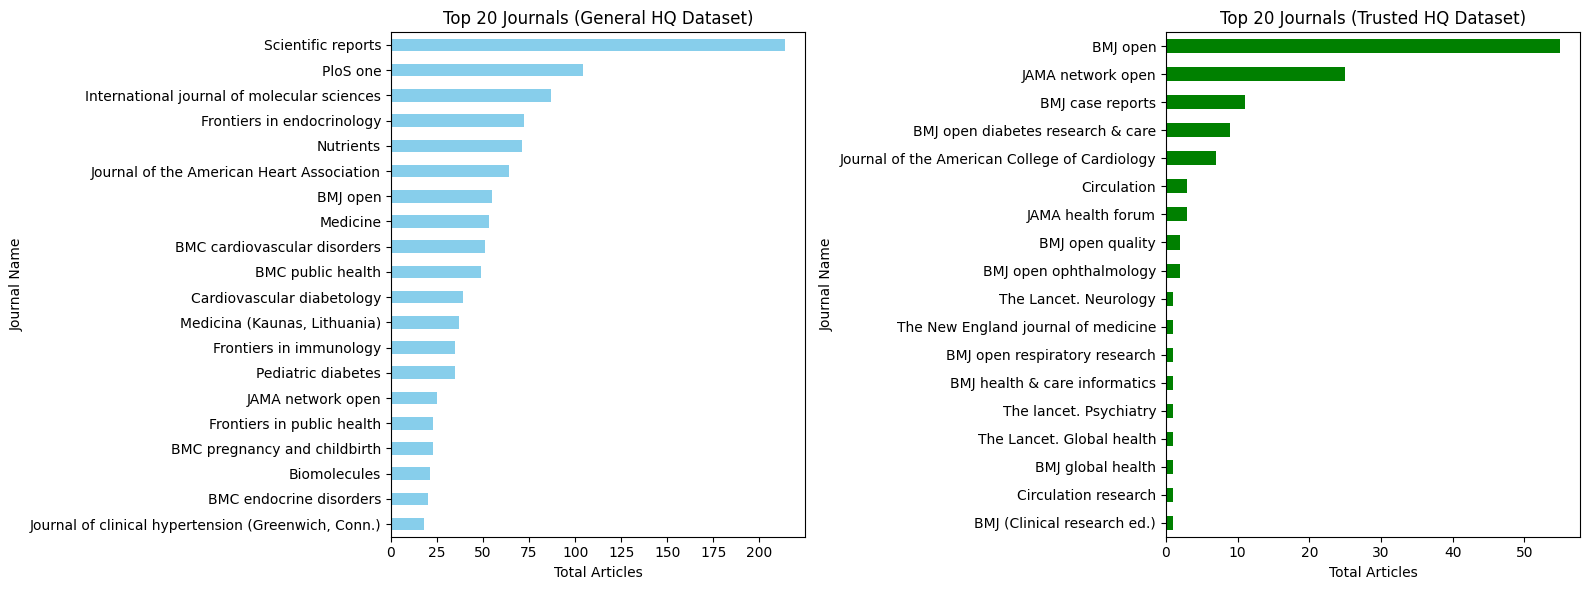

In [ ]:
# EDA number of article each journal from all data and subset
# Count the number of articles per journal for both datasets
journal_counts_general = df_general['Journal'].value_counts().head(20)
journal_counts_trusted = df_trusted['Journal'].value_counts().head(20)

# Display as tables
print("📚 Top 20 Journals with the Most Articles (General HQ Dataset):")
print(journal_counts_general)

print("\n📚 Top 20 Journals with the Most Articles (Trusted HQ Dataset):")
print(journal_counts_trusted)

# Plot both charts side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# General HQ Dataset plot
journal_counts_general.sort_values().plot(kind='barh', color='skyblue', ax=axes[0])
axes[0].set_title("Top 20 Journals (General HQ Dataset)")
axes[0].set_xlabel("Total Articles")
axes[0].set_ylabel("Journal Name")

# Trusted HQ Dataset plot
journal_counts_trusted.sort_values().plot(kind='barh', color='green', ax=axes[1])
axes[1].set_title("Top 20 Journals (Trusted HQ Dataset)")
axes[1].set_xlabel("Total Articles")
axes[1].set_ylabel("Journal Name")

plt.tight_layout()
plt.show()


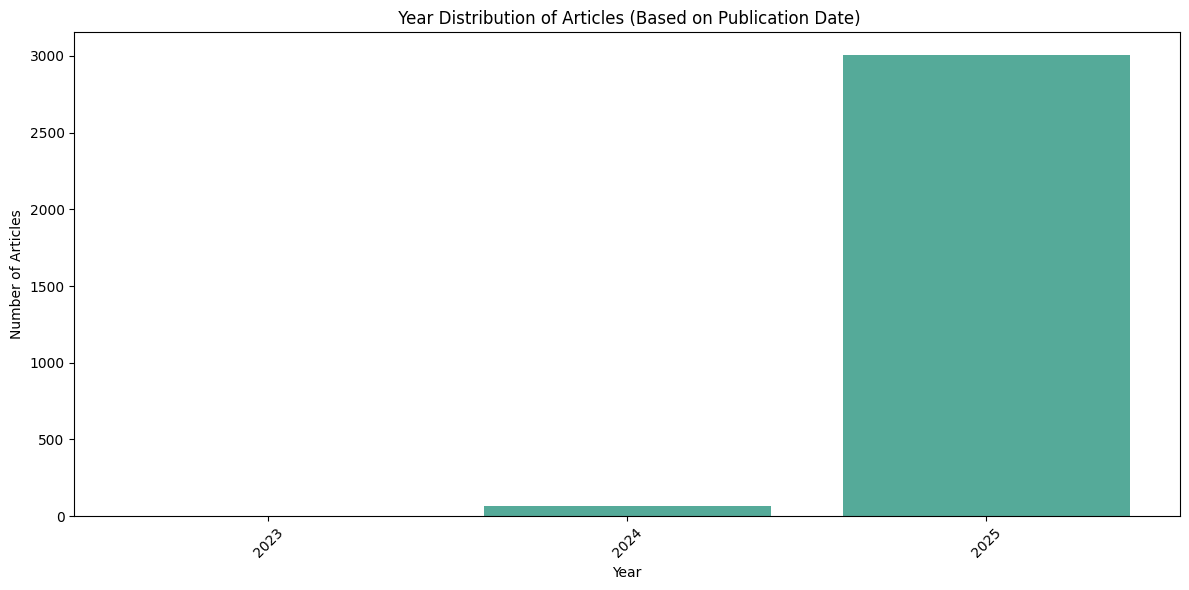

In [ ]:
# Prepare data for histogram: group by year
df_general["PublishedYear"] = df_general["PublishedDate"].dt.to_period("Y")
monthly_counts = df_general["PublishedYear"].value_counts().sort_index()

#  Plot histogram with month-based x-axis
# Convert PeriodIndex to string for x-axis labels
x_labels = monthly_counts.index.astype(str)

plt.figure(figsize=(12, 6))
plt.bar(x_labels, monthly_counts.values, color="#5A9")
plt.title(" Year Distribution of Articles (Based on Publication Date)")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The papers that have been obtained and are in accordance with the specified topic are mostly in 2025, confirming that the corpus truly captures the latest cardiovascular, including stroke and diabetes research, and some are also in 2024 and 2023.

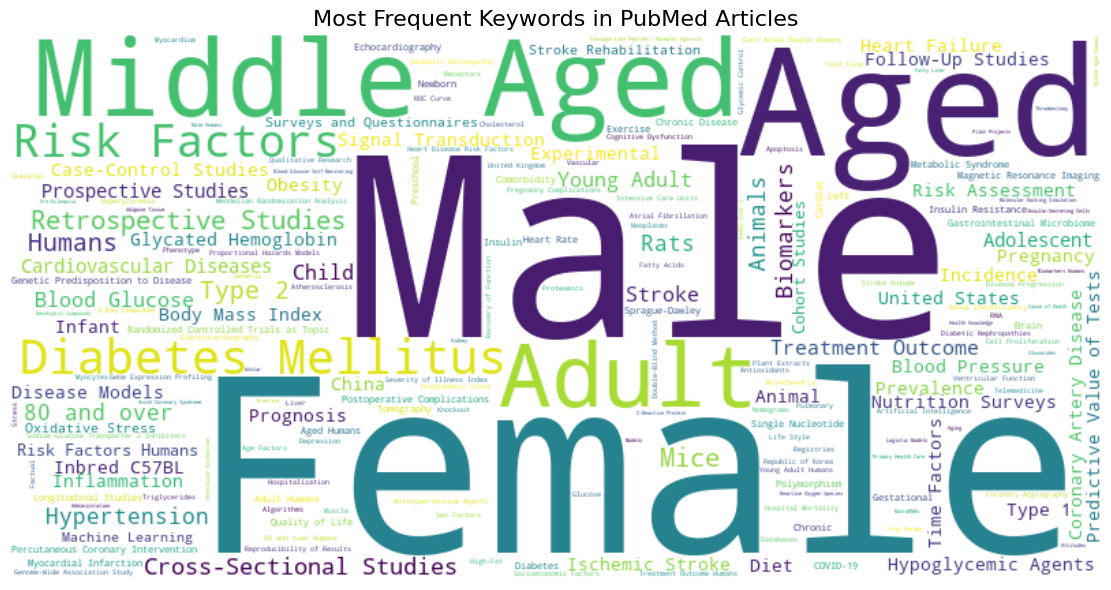

In [ ]:
from collections import Counter  # For counting frequency of elements in a list or iterable
from wordcloud import WordCloud  # For generating word cloud visualizations from text data

#EDA for most keywords that appear in the data

# Combine all keywords into a single string
all_keywords = ' '.join(df_general['Keywords'].tolist())

# Tokenize and remove extra spaces
keywords_list = [keyword.strip() for keyword in all_keywords.split(',')]

# Count frequency of each keyword
keyword_counts = Counter(keywords_list)
# Create WordCloud from keyword frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

# Display the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Keywords in PubMed Articles", fontsize=16)
plt.tight_layout()
plt.show()


MeSh tags or article keywords are dominated by patient descriptors ("Male", "Female", "Middle-Aged") and also core CVD terms such as ("Diabetes Mellitus", "Hypertension", "Stroke") indicating that the articles obtained focus on human clinical studies rather than experiments on animals.

## Chunking and Embeddings

### Chunking

Semantic chunking via Langchain is used as the primary approach, where sentence embedding will be grouped based on cosine similarity to maintain topical coherence and improve the retrieval process's relevance.

For LLM performance comparison later and enables fair benchmarking, fixed size chunk is also implemented with 400 token windows with 50 token overlap.

#### Fixed size chunking set up

Calculate and explore token length

count    3069.000000
mean      400.966113
std       134.138820
min       116.000000
25%       316.000000
50%       387.000000
75%       468.000000
max      1471.000000
Name: Abstract, dtype: float64


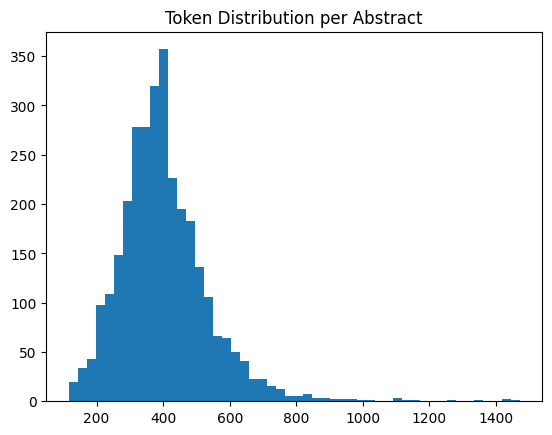

In [ ]:
import tiktoken  # For counting tokens as used by OpenAI models

# Load the tokenizer specific to the GPT-3.5 Turbo model to ensure accurate token count
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

token_lens = df_general['Abstract'].apply(lambda x: len(enc.encode(x)))
print(token_lens.describe())        # See the descriptive statistics

plt.hist(token_lens, bins=50)
plt.title("Token Distribution per Abstract")
plt.show()

The average of abstract's token is 401 tokens or between 267-535 tokens with a maximum of only 1471, meaning that the majority of data can be embedded without the need for a lot of truncation which used for fixed size chunk

In [ ]:
# Chunking parameters
CHUNK_SIZE = 400         # Target length for each chunk (in tokens)
OVERLAP = 50             # Overlap between chunks to preserve context continuity

# Function to split text into fixed-size overlapping token chunks
def fixed_chunk(text: str):
    tokens = enc.encode(text)  # Convert text to tokens using GPT-3.5 Turbo tokenizer
    chunks = []
    for i in range(0, len(tokens), CHUNK_SIZE - OVERLAP):
        sub = tokens[i : i + CHUNK_SIZE]  # Extract a chunk of CHUNK_SIZE tokens
        chunks.append(enc.decode(sub))    # Convert tokens back to string and store
        if i + CHUNK_SIZE >= len(tokens):  # Stop if end of token list is reached
            break
    return chunks


#### Semantic Chunking set up

In [ ]:
# Langchain: for embedding generation and semantic-aware text splitting
from langchain_huggingface import HuggingFaceEmbeddings  # For generating embeddings using HuggingFace models
from langchain_experimental.text_splitter import SemanticChunker  # For semantically splitting long texts into meaningful chunks
from langchain_core.documents import Document  # For representing text chunks as Document objects used in Langchain pipelines

In [ ]:
# Initialize the embedding model
# Using BGE-small for its efficient and high-quality embeddings, which help SemanticChunker detect semantically coherent breakpoints.
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

# Initialize the semantic text chunker
chunker = SemanticChunker(
    embeddings=embedding_model,              # Use BGE embeddings for semantic splitting
    breakpoint_threshold_type="percentile"   # Use percentile-based similarity to decide breakpoints
)

# Function to split a given text (e.g., an abstract) into semantically coherent chunks
def semantic_chunk(text: str):
    doc = Document(page_content=text)        # Wrap the text into a Langchain Document object
    return chunker.split_documents([doc])    # Return a list of semantically chunked Document objects


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Chunking Abstracts with Fixed-Size and Semantic Methods

In [ ]:
# Prepare lists to store chunking results
docs_fixed = []
docs_sem = []

# Iterate over each row in the DataFrame with a progress bar
for idx, row in tqdm(df_general.iterrows(), total=len(df_general), desc="⏳ Chunking Documents"):

    # Apply fixed-size chunking
    for n, chunk in enumerate(fixed_chunk(row["Abstract"])):
        docs_fixed.append({
            "id": f"{row.PMID}_f{n}",         # Unique ID for each fixed chunk
            "pmid": str(row.PMID),            # Store PMID for reference
            "text": chunk,                    # Text content of the chunk
            "chunk_type": "fixed"             # Label the chunk type
        })

    # Apply semantic chunking (using BGE embeddings + LangChain)
    sem_chunks = semantic_chunk(row["Abstract"])
    for n, doc in enumerate(sem_chunks):
        docs_sem.append({
            "id": f"{row.PMID}_s{n}",         # Unique ID for each semantic chunk
            "pmid": str(row.PMID),            # Store PMID for reference
            "text": doc.page_content,         # Text content produced by SemanticChunker
            "chunk_type": "semantic"          # Label the chunk type
        })

# Print summary of chunk counts
print(f"📦 Fixed chunks: {len(docs_fixed)}")
print(f"🧩 Semantic chunks: {len(docs_sem)}")


⏳ Chunking Documents: 100%|██████████| 3069/3069 [01:03<00:00, 48.03it/s]

📦 Fixed chunks: 4497
🧩 Semantic chunks: 6166


Semantic chunking tends to generate more chunks, as many as 6166 chunks because the chunks adaptively follow meaningful sentences/paragraphs. While fixed chunks are more efficient but can be “too dense”, sometimes one chunk contains a lot of mixed information, where 4497 ​​chunks are obtained.

In [ ]:
# Preview 3 sample results from fixed-size chunking
import random
print("📦 Sample Fixed Chunks:\n")
for doc in random.sample(docs_fixed, 3):
    print(f"🔹 ID: {doc['id']}\n{doc['text'][:500]}...\n{'-'*80}")

# Preview 3 sample results from semantic chunking
print("\n🧩 Sample Semantic Chunks:\n")
for doc in random.sample(docs_sem, 3):
    print(f"🔸 ID: {doc['id']}\n{doc['text'][:500]}...\n{'-'*80}")


📦 Sample Fixed Chunks:

🔹 ID: 40346499_f0
The triglyceride‒glucose body mass index (TyG-BMI) has been recognized as a significant predictor of cardiovascular disease risk and plays a crucial role in assessing insulin resistance. However, the correlation between the TyG-BMI and clinical outcomes in patients with sepsis and acute heart failure (AHF) has not been sufficiently explored. This study aimed to investigate the associations between TyG-BMI and clinical outcomes in patients with sepsis and AHF. We conducted a retrospective analysi...
--------------------------------------------------------------------------------
🔹 ID: 40342425_f0
Neutrophil Extracellular Traps (NETs) are vital for innate immunity, playing a key role in controlling pathogen and biofilm proliferation. However, excessive NETosis is implicated in autoimmunity, inflammatory and neoplastic diseases, as well as thrombosis, stroke, and post-COVID-19 complications. Managing NETosis, therefore is a significant area of ong

## Embedding

The embedding process itself uses BAAI/bge-small-en-v1.5, a 384-dimensional bi-encoder optimised for retrieval tasks and instruction-style prompts. Given that the average token distribution in the abstract is 400, this approach is also suitable for this project.


In [ ]:
from sentence_transformers import SentenceTransformer  # For sentence-level embedding generation
# Initialize BGE-small v1.5 model for embedding
# This model is optimized for dense retrieval and semantic similarity in English.
# Used here to convert text chunks into vectors for vector database indexing.
model = SentenceTransformer("BAAI/bge-small-en-v1.5")
# Function to encode a list of texts into embeddings
def embed(texts):
    return model.encode(
        texts,
        batch_size=64,              # Efficient batch size for GPU/CPU
        show_progress_bar=True,     # Show progress bar during encoding
        normalize_embeddings=True   # Normalize to unit vectors for cosine similarity
    )


## Vector Storage

Vector storage uses ChromaDB because it has fast approximate-nearest-neighbor capabilities and seamless integration with Langchain. Plus, it's built for lightweight setup and is ideal for reproducible experiments in limited resources like Google Colab

In [ ]:
import chromadb  # Chroma: lightweight embedding database for semantic search

# Initialize Chroma client with persistent storage in the local 'chroma_db' folder
client = chromadb.PersistentClient(path="chroma_db")


In [ ]:
# Ensure all PMIDs are stored as strings for metadata consistency
for doc in docs_fixed:
    doc["pmid"] = str(doc["pmid"])
for doc in docs_sem:
    doc["pmid"] = str(doc["pmid"])

# -------------------------------------------------------------------
# Function to insert a list of chunked documents into a Chroma vector collection
# -------------------------------------------------------------------
def insert_chunks_to_chroma(collection_name, docs):
    # Retrieve an existing collection or create one if it doesn't exist
    collection = client.get_or_create_collection(collection_name)

    # Split the input into batches to avoid memory issues during insertion
    batch_size = 200
    for i in range(0, len(docs), batch_size):
        batch = docs[i : i + batch_size]

        # Prepare input for Chroma
        ids = [doc["id"] for doc in batch]  # Unique identifier per chunk
        texts = [doc["text"] for doc in batch]  # Raw text of the chunk
        metas = [
            {
                "pmid": str(doc["pmid"]),             # PMID for traceability
                "chunk_type": doc["chunk_type"]       # Chunking method label
            }
            for doc in batch
        ]
        embeddings = embed(texts)  # Generate vector embeddings using BGE model

        # Insert the batch into the specified Chroma collection
        collection.add(
            ids=ids,
            documents=texts,
            metadatas=metas,
            embeddings=embeddings
        )
        print(f"✅ Batch {i // batch_size + 1} inserted into collection '{collection_name}'")

# Insert fixed-size chunks into the 'chunks_fixed' Chroma collection
insert_chunks_to_chroma("chunks_fixed", docs_fixed)

# Insert semantic chunks into the 'chunks_semantic' Chroma collection
insert_chunks_to_chroma("chunks_semantic", docs_sem)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 1 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 2 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 3 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 4 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 5 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 6 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 7 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 8 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 9 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 10 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 11 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 12 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 13 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 14 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 15 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 16 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 17 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 18 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 19 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 20 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 21 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 22 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Batch 23 inserted into collection 'chunks_fixed'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 1 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 2 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 3 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 4 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 5 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 6 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 7 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 8 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 9 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 10 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 11 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 12 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 13 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 14 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 15 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 16 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 17 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 18 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 19 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 20 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 21 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 22 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 23 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 24 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 25 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 26 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 27 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 28 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 29 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Batch 30 inserted into collection 'chunks_semantic'


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Batch 31 inserted into collection 'chunks_semantic'


# Retrieval & Reranking

### Query list

30 questions were created with various difficulties, such as :

**Easy** (straightforward factual questions)

**Ambiguous** (questions that have multiple interpretations or require guidance)

**Domain specific** (require synthesis of current evidence)

Each difficulty is divided into several topics, such as single topic, cross topic, and natural style (informal clinician question), which align with the retrieval corpus in CVD, stroke and diabetes.

In [ ]:
query_list = [

    # --- Single-topic queries ---
    "What does ‘lipoprotein(a)’ refer to?",     # easy - lipid
    "Is ezetimibe still recommended as an add-on to statins in 2025 cardiovascular guidelines for patients with elevated LDL?",      # ambiguous - lipid
    "Are there randomized trials evaluating the cardiovascular benefits of ezetimibe in patients with both diabetes and heart failure?",  # domain-specific - lipid
    "What is the role of left atrial appendage closure in cardiovascular treatment?",  # easy - structural
    "Is left atrial appendage closure still recommended for atrial fibrillation patients with high bleeding risk in 2025 guidelines?",   # ambiguous - structural
    "Have any RCTs examined the safety and efficacy of left atrial appendage closure in patients with both diabetes and heart failure?", # domain-specific - structural
    "What is the role of bempedoic acid in cardiovascular treatment?",               # easy - lipid
    "Is bempedoic acid endorsed in 2025 lipid management guidelines as an alternative when statins and ezetimibe are insufficient?",   # ambiguous - lipid
    "What is the role of GLP-1 AND diabetes in cardiovascular treatment?",           # easy - metabolic
    "What do recent RCTs show about cardiovascular outcomes of GLP-1 agonists in diabetic patients with co-morbid heart failure?", # domain-specific - metabolic

    # --- Cross-topic queries ---
    "How can PCSK9-inhibitors and AI-based risk prediction be combined in lipid management?",  # easy - lipid + AI
    "Are clinical decisions on stenting—such as timing or antiplatelet therapy—being influenced by atrial fibrillation detected through smartwatches?",        # ambiguous - AI + stent
    "Do 2024–2025 RCTs evaluate the use of SGLT2 inhibitors in HFpEF patients monitored by ambulatory blood pressure devices?",  # domain-specific - SGLT2 + BP monitoring
    "Do DOACs remain safe in elderly AF patients enrolled in tele-rehab programmes?",          # easy - anticoag + rehab
    "Is dual antiplatelet therapy still recommended after stroke in patients who undergo endovascular thrombectomy?",     # ambiguous - antiplatelet + stroke
    "Are there studies reporting late lumen loss in diabetic CAD patients receiving GLP-1 agonists post drug-eluting stents?",  # domain-specific - stent + GLP-1
    "What role does remote cardiac rehabilitation play after ventricular tachycardia ablation?",                    # easy - rehab + arrhythmia
    "Can AI-based ECG analysis be used to estimate or predict lipoprotein(a) levels in clinical practice?",       # ambiguous - AI + lipid
    "How do post-procedural antithrombotic regimens differ between tricuspid edge-to-edge repair and TAVI in frail elderly patients?",  # domain-specific - devices + anticoag
    "How does bempedoic acid interact with smartwatch-based lifestyle coaching apps?",                              # easy - lipid + wearable

    # --- Natural-style everyday queries ---
    "I’ve heard GLP-1 drugs help with heart problems — how true is that?",          # easy - GLP-1, Heart Failure
    "Can a smartwatch really detect dangerous heart rhythms?",                      # easy - AI diagnostics, Arrhythmia
    "Should people with high cholesterol be worried about lipoprotein(a)?",         # easy - Lipids, Lp(a)
    "What’s the difference between TAVI and open-heart valve surgery?",             # easy - Structural heart
    "What do current guidelines say about stopping one antiplatelet agent after the acute phase of ischemic stroke?",   # ambiguous - Antiplatelet
    "How useful is remote rehab after a heart attack?",                              # easy - Tele-rehab
    "What are the cardiovascular and renal benefits of SGLT2 inhibitors in non-diabetic heart failure patients?",  # domain-specific - SGLT2
    "Do AI-enhanced ECG interpretation tools improve diagnostic accuracy or reduce errors compared to traditional reading by cardiologists?",# ambiguous - AI ECG
    "Is bempedoic acid a clinically viable monotherapy alternative to statins in patients with hyperlipidemia?",    # ambiguous - Lipid
    "How do pathophysiology, prognosis, and treatment response differ between HFpEF and HFrEF patients?"  # domain-specific - HFpEF
]


### Hybrid Retrieval and Reranking

A hybrid approach is used for the retrieval process by combining BM25 for keyword search and dense retrieval with BGE-small to capture semantic meaning. Moreover, the reranker approach is also used to improve the relevance and re-filter the retrieval results using BAAI/bge-reranker-large

In [ ]:
from sentence_transformers import CrossEncoder  # For reranking document-query pairs using dense cross-encoding
from rank_bm25 import BM25Okapi                # For traditional lexical retrieval using BM25 algorithm
import spacy                                   # For NLP preprocessing (e.g., tokenization, lemmatization) mainly for the rank_bm25

 Hybrid Retrieval Pipeline: BM25 + Dense vector retrieval + Cross-Encoder Reranking


In [ ]:
# Load a lightweight English model from spaCy (disable parser and NER for speed)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Custom tokenizer: lowercased lemmatization, removing stopwords and non-alphabetic tokens
def tokenize_spacy(text):
    return [
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ]

# Prepare the corpus from abstracts, replacing missing entries with empty strings
corpus = df_general["Abstract"].fillna("").tolist()

# Tokenize the entire corpus using spaCy with a progress bar
tokenized_corpus = [tokenize_spacy(doc) for doc in tqdm(corpus, desc="🔍 Tokenizing corpus with spaCy")]

# Build a lexical retrieval index using BM25
bm25 = BM25Okapi(tokenized_corpus)

# Initialize persistent Chroma client for vector store access
client = chromadb.PersistentClient(path="chroma_db")

# Load embedding and reranking models
embedder = SentenceTransformer("BAAI/bge-small-en-v1.5")  # For dense vector retrieval
reranker = CrossEncoder("BAAI/bge-reranker-large")        # For final cross-encoder reranking

# Wrapper for embedding using BGE-small (normalized for cosine similarity)
def embed(texts):
    return embedder.encode(texts, normalize_embeddings=True)

# Retrieval pipeline: only semantic chunks
def hybrid_retrieve_semantic_only(query, top_bm25=10, top_vector=10, top_final=5):
    collection = client.get_collection("chunks_semantic")
    return _retrieve_and_rerank(query, collection, top_bm25, top_vector, top_final)

# Retrieval pipeline: only fixed-size chunks
def hybrid_retrieve_fixed_only(query, top_bm25=10, top_vector=10, top_final=5):
    collection = client.get_collection("chunks_fixed")
    return _retrieve_and_rerank(query, collection, top_bm25, top_vector, top_final)

# Shared internal function for hybrid retrieval and reranking
def _retrieve_and_rerank(query, collection, top_bm25, top_vector, top_final):
    # Step 1: Lexical retrieval using BM25
    tokenized_query = tokenize_spacy(query)
    bm25_scores = bm25.get_scores(tokenized_query)
    top_bm25_idx = np.argsort(bm25_scores)[::-1][:top_bm25]

    bm25_results = [{
        "text": corpus[i],
        "bm25_score": bm25_scores[i],
        "pmid": str(df_general.iloc[i]["PMID"]),
        "chunk_type": "bm25",
        "source": f"bm25_{i}"
    } for i in top_bm25_idx]

    # Step 2: Dense retrieval using Chroma + BGE embedding
    query_embedding = embed([query])
    vector_results = collection.query(
        query_embeddings=query_embedding,
        n_results=top_vector,
        include=["documents", "metadatas"]
    )

    vector_hits = [{
        "id": meta.get("id", f"{collection.name}_{i}"),
        "text": doc,
        "pmid": meta.get("pmid", ""),
        "chunk_type": meta.get("chunk_type", collection.name),
        "source": f"{collection.name}_idx_{i}"
    } for i, (doc, meta) in enumerate(zip(vector_results["documents"][0], vector_results["metadatas"][0]))]

    # Step 3: Combine BM25 + vector results, remove duplicates
    combined = {}
    for item in bm25_results + vector_hits:
        key = item.get("id", item["text"])  # Prefer ID if available, fallback to text
        combined[key] = item
    combined_list = list(combined.values())

    # Step 4: Cross-encoder reranking
    pairs = [[query, item["text"]] for item in combined_list]
    scores = reranker.predict(pairs)
    for item, score in zip(combined_list, scores):
        item["rerank_score"] = float(score)

    # Step 5: Return top-N reranked results
    # Only the top `top_final` results will be returned (default = 5)
    top_reranked = sorted(combined_list, key=lambda x: x["rerank_score"], reverse=True)
    return top_reranked[:top_final]


🔍 Tokenizing corpus with spaCy: 100%|██████████| 3069/3069 [01:02<00:00, 49.01it/s]


config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

In [ ]:
# Define the test query
query = "Should people with high cholesterol be worried about lipoprotein(a)?"

# Run hybrid retrieval separately on semantic and fixed chunk collections
semantic_only = hybrid_retrieve_semantic_only(query)
fixed_only = hybrid_retrieve_fixed_only(query)

# === Display Results for Comparison ===

print("\n===== SEMANTIC CHUNK RESULTS =====")
for i, res in enumerate(tqdm(semantic_only, desc="🧩 Semantic chunks"), 1):
    print(f"[SEMANTIC #{i}] PMID: {res.get('pmid', '-')}, Score: {res['rerank_score']:.2f}")
    print(res['text'][:250] + "...\n")  # Preview only first 250 characters

print("\n===== FIXED CHUNK RESULTS =====")
for i, res in enumerate(tqdm(fixed_only, desc="📦 Fixed chunks"), 1):
    print(f"[FIXED #{i}] PMID: {res.get('pmid', '-')}, Score: {res['rerank_score']:.2f}")
    print(res['text'][:250] + "...\n")  # Preview only first 250 characters



===== SEMANTIC CHUNK RESULTS =====


🧩 Semantic chunks: 100%|██████████| 5/5 [00:00<00:00, 26313.07it/s]


[SEMANTIC #1] PMID: 40370778, Score: 0.98
Individuals in the low Lp(a) (OR=2.12, 95% CI 1.17-3.84, <i>P</i><0.05), intermediate Lp(a) (OR=2.76, 95% CI 1.10-6.98, <i>P</i><0.05) and high Lp(a) (OR=4.79, 95% CI 2.03-11.31, <i>P</i><0.01) groups had an increased risk of coronary heart disease (...

[SEMANTIC #2] PMID: 40331566, Score: 0.91
High Lp(a) concentrations are linked to an increased risk of cardiovascular disease (CVD). However, more evidence is needed to assess the association of Lp(a) with CVD in different vascular beds. The aim was to assess the prevalence of increased Lp(a...

[SEMANTIC #3] PMID: 40258460, Score: 0.13
Elevated lipoprotein(a) (Lp[a]) is a genetically determined cardiovascular risk factor, linked to both atherosclerotic cardiovascular disease and aortic stenosis. Elevated Lp(a) is widely prevalent, and consequently, several cardiovascular societies ...

[SEMANTIC #4] PMID: 40331644, Score: 0.09
The median Lp(a) concentration in women was higher than in men, 12.

📦 Fixed chunks: 100%|██████████| 5/5 [00:00<00:00, 37786.52it/s]

[FIXED #1] PMID: 40331566, Score: 0.93
High Lp(a) concentrations are linked to an increased risk of cardiovascular disease (CVD). However, more evidence is needed to assess the association of Lp(a) with CVD in different vascular beds. The aim was to assess the prevalence of increased Lp(a...

[FIXED #2] PMID: 40327115, Score: 0.08
Post-stroke cognitive impairment (PSCI) affects 15-70% of ischemic stroke survivors, with vascular dementia contributing significantly to long-term disability. Lipoprotein(a) [Lp(a)] has emerged as a key risk factor for cardiovascular and cerebrovasc...

[FIXED #3] PMID: 40258460, Score: 0.07
Elevated lipoprotein(a) (Lp[a]) is a genetically determined cardiovascular risk factor, linked to both atherosclerotic cardiovascular disease and aortic stenosis. Elevated Lp(a) is widely prevalent, and consequently, several cardiovascular societies ...

[FIXED #4] PMID: 40305153, Score: 0.05
The accumulation of high levels of cholesterol associated with low-density lipo

From the hybrid retrieval and rerank results, Semantic chunking produces more relevant and dense contexts than fixed-size, as seen from the higher reranking scores (e.g. 0.98, 0.91 compared to fixed only 0.93 and 0.08). Fixed chunks are still able to find relevant documents but tend to be broader and less focused due to token-based chunk constraints.

In [ ]:
#Run Retrieval for All Queries and Prepare Input for RAGAS Evaluation
# Initialize a list to collect all retrieved chunks (semantic + fixed)
all_results = []

#  Loop over each query in the test set (e.g., 30 curated questions)
for question in tqdm(query_list, desc="🔍 Retrieving chunks for all queries"):

    # Retrieve top-N semantic chunks for the current query(in here i set it to top 5)
    for res in hybrid_retrieve_semantic_only(question, top_final=5):
        all_results.append({
            "query": question,
            "pmid": res.get("pmid", "-"),               # PubMed ID for traceability
            "rerank_score": res.get("rerank_score", None),
            "chunk_type": "semantic",                   # Label to distinguish chunking method
            "context": res["text"]
        })

    # Retrieve top-N fixed-size chunks for the same query (in here i set it to top 5)
    for res in hybrid_retrieve_fixed_only(question, top_final=5):
        all_results.append({
            "query": question,
            "pmid": res.get("pmid", "-"),
            "rerank_score": res.get("rerank_score", None),
            "chunk_type": "fixed",
            "context": res["text"]
        })

# Convert the collected results into a DataFrame format for evaluation (e.g., RAGAS)
df_ragas_input = pd.DataFrame(all_results)



🔍 Retrieving chunks for all queries: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


# LLM


The LLM used is the open-source model Mistral-7B-Instruct-v0.3. This model has 7 billion parameters and is used because it is efficient when run and supports prompt alignment with the "question - context-answer" style, which is suitable for medical RAG scenarios.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM  # For loading pretrained language models (e.g., LLaMA, Mistral, GPT-style)
import os                                                    # For interacting with the operating system and environment
from google.colab import userdata                            # For securely retrieving secrets from Colab (e.g., HuggingFace and Open AI token)
import torch                                                 # For managing tensor operations and model execution (CPU/GPU)

In [ ]:
# This prompt is designed for Medical Q&A purposes, which require precise answers regarding specific domains and terms and requires LLM to:
# - Only use evidence provided from the scientific context in which the evidence is taken, especially based on the article that has been taken
# - Avoid hallucinations or introduction of unsupported information
# - Provide clear and medically accountable output in high-risk domains
PROMPT_MEDPROMPT = """
**Important Disclaimer:** This information is for educational and informational purposes only and does not constitute medical advice. Always consult a qualified healthcare professional for diagnosis and treatment.

You are a clinical assistant specializing in interpreting recent scientific findings. Your primary goal is to provide accurate, context-grounded, evidence-based responses.

**Task:** Answer the following medical question *solely* based on the provided research context.

**Instructions:**
1. **Use ONLY the information in the context below.** Do not infer, speculate, or introduce external knowledge.
2. **Be precise and direct.** Clearly answer the question without generalizations or vague statements.
3. **Step-by-step reasoning** is encouraged only when needed to connect context evidence to the final answer.
4. **Handling uncertainty:** If the context does not contain enough information, clearly state that — do not guess or assume.
5. **Output Format:** Respond concisely in a single paragraph.

---

**Question:**
{question}

**Context:**
{context}

---

**Answer:**
"""


In [ ]:
#  Securely load Hugging Face token from Colab's secret storage
hf_token = userdata.get("HF_TOKEN")  # Retrieved from environment variable or user input

# Specify the model ID (must have access granted via Hugging Face account)
model_id = "mistralai/Mistral-7B-Instruct-v0.3"

# Load the tokenizer with the authentication token
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    token=hf_token  # Required for gated model access
)

#  Load the causal language model with GPU support and memory-efficient settings
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token=hf_token,               # Secure access
    device_map="auto",            # Automatically map model to GPU if available
    torch_dtype=torch.float16,    # Use half-precision for speed/memory optimization
    low_cpu_mem_usage=True        # Reduce CPU RAM usage during model loading
)

# Generate LLM answer using MedPrompt-style or a prompt that has been set before for controlling prompt formatting
def generate_llm_answer(question, context):
    # Construct a grounded, constrained prompt using the MedPrompt template
    prompt = PROMPT_MEDPROMPT.format(question=question, context=context)

    # Tokenize the prompt and move it to CUDA (GPU)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Run model inference (greedy decoding, no sampling)
    outputs = model.generate(
        **inputs,
        max_new_tokens=768,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode raw model output to text
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the answer portion (after "**Answer:**")
    if "**Answer:**" in decoded:
        final_answer = decoded.split("**Answer:**", 1)[1].strip()
    else:
        final_answer = decoded.strip()

    return final_answer


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Test from different queries list (Easy, Ambiguous and Domain Specific)


Conducting strict testing with various questions, both easy, ambiguous and domain with semantic and fixed chunks as well as zero shots or pure from Mistral 7B/LLM itself

#### Easy

In [ ]:
# Define the test query from the query list
query = "I’ve heard GLP-1 drugs help with heart problems — how true is that?"

# Retrieve top-3 semantically chunked context segments from the vector store
semantic_results = hybrid_retrieve_semantic_only(query, top_final=3)
semantic_context = "\n\n".join([res["text"] for res in semantic_results])
semantic_pmids = [str(res.get("pmid", "N/A")) for res in semantic_results]

# Retrieve top-3 fixed-size chunked context segments from the vector store
fixed_results = hybrid_retrieve_fixed_only(query, top_final=3)
fixed_context = "\n\n".join([res["text"] for res in fixed_results])
fixed_pmids = [str(res.get("pmid", "N/A")) for res in fixed_results]

# Run generation for each retrieval type
answer_semantic = generate_llm_answer(query, semantic_context)   # with semantic chunk context
answer_fixed = generate_llm_answer(query, fixed_context)         # with fixed chunk context
answer_zero_shot = generate_llm_answer(query, "")                # no context at all (zero-shot)

# Display the output to compare different retrieval modes
print(f"\n📌 QUESTION:\n{query}")

print("\n📚 SEMANTIC CHUNKS RESULT:")
print(answer_semantic)
print(f"📄 Source: PMID(s) {', '.join(semantic_pmids)}")

print("\n📦 FIXED CHUNKS RESULT:")
print(answer_fixed)
print(f"📄 Source: PMID(s) {', '.join(fixed_pmids)}")

print("\n🧠 ZERO-SHOT RESULT:")
print(answer_zero_shot)

print("=" * 100)



📌 QUESTION:
I’ve heard GLP-1 drugs help with heart problems — how true is that?

📚 SEMANTIC CHUNKS RESULT:
Yes, GLP-1 drugs have shown promise in managing heart failure with preserved ejection fraction (HFpEF) in obese populations. Clinical trials such as STEP-HFpEF and SUMMIT have demonstrated that GLP-1 receptor agonists like semaglutide and tirzepatide reduce body weight, enhance exercise capacity, improve quality of life, and decrease systemic inflammation in obese patients with HFpEF. However, it's important to note that the current evidence is limited by short trial durations, lack of population diversity, and insufficient long-term data.
📄 Source: PMID(s) 40366488, 40295996, 40279852

📦 FIXED CHUNKS RESULT:
GLP-1 drugs have shown promise in managing heart failure with preserved ejection fraction (HFpEF) in obese populations, as demonstrated by significant reductions in body weight, improvements in exercise capacity, and quality of life, as well as marked reductions in systemic 

Semantic chunks provide better answers, with more emphasis on the answer side of the clinical trial name (STEP-HFpEF, SUMMIT) and specific mechanisms showing strong grounding ability. while, zero-shot fails to answer because it does not have sufficient supporting context that matches the instructions of the prompt that has been created.

#### Ambigous

In [ ]:
# Define the test query from the query list
query = "Is dual antiplatelet therapy still recommended after stroke in patients who undergo endovascular thrombectomy?"

# Retrieve top-3 semantically chunked context segments from the vector store
semantic_results = hybrid_retrieve_semantic_only(query, top_final=3)
semantic_context = "\n\n".join([res["text"] for res in semantic_results])
semantic_pmids = [str(res.get("pmid", "N/A")) for res in semantic_results]

# Retrieve top-3 fixed-size chunked context segments from the vector store
fixed_results = hybrid_retrieve_fixed_only(query, top_final=3)
fixed_context = "\n\n".join([res["text"] for res in fixed_results])
fixed_pmids = [str(res.get("pmid", "N/A")) for res in fixed_results]

# Run generation for each retrieval type
answer_semantic = generate_llm_answer(query, semantic_context)   # with semantic chunk context
answer_fixed = generate_llm_answer(query, fixed_context)         # with fixed chunk context
answer_zero_shot = generate_llm_answer(query, "")                # no context at all (zero-shot)

# Display the output to compare different retrieval modes
print(f"\n📌 QUESTION:\n{query}")

print("\n📚 SEMANTIC CHUNKS RESULT:")
print(answer_semantic)
print(f"📄 Source: PMID(s) {', '.join(semantic_pmids)}")

print("\n📦 FIXED CHUNKS RESULT:")
print(answer_fixed)
print(f"📄 Source: PMID(s) {', '.join(fixed_pmids)}")

print("\n🧠 ZERO-SHOT RESULT:")
print(answer_zero_shot)

print("=" * 100)



📌 QUESTION:
Is dual antiplatelet therapy still recommended after stroke in patients who undergo endovascular thrombectomy?

📚 SEMANTIC CHUNKS RESULT:
Based on the provided context, dual antiplatelet therapy (DAPT) is not explicitly recommended for stroke patients who undergo endovascular thrombectomy. The study on real-world DAPT application in patients with ischemic stroke or transient ischemic attack (READAPT) shows that DAPT use in patients with large artery atherosclerosis (LAA) exceeds RCT boundaries, with possible drawbacks on treatment safety, particularly increased bleeding rates. However, the study does not specifically address the use of DAPT in patients undergoing endovascular thrombectomy. The other study investigates the impact of cerebral edema on functional outcomes in patients with ischemic stroke treated with thrombectomy, but it does not discuss the role of DAPT in this context. Therefore, the information provided does not allow for a definitive conclusion about the 

Semantic chunks show uncertainty about the context of the answer that does not explicitly discuss DAPT-post-thrombectomy with caution compared to fixed chunking, which still mixes irrelevant context. Zero-shot also fails to provide the correct answer.

#### Domain-Specific

In [ ]:
# Define the test query from the query list
query = "What are the cardiovascular and renal benefits of SGLT2 inhibitors in non-diabetic heart failure patients?"

# Retrieve top-3 semantically chunked context segments from the vector store
semantic_results = hybrid_retrieve_semantic_only(query, top_final=3)
semantic_context = "\n\n".join([res["text"] for res in semantic_results])
semantic_pmids = [str(res.get("pmid", "N/A")) for res in semantic_results]

# Retrieve top-3 fixed-size chunked context segments from the vector store
fixed_results = hybrid_retrieve_fixed_only(query, top_final=3)
fixed_context = "\n\n".join([res["text"] for res in fixed_results])
fixed_pmids = [str(res.get("pmid", "N/A")) for res in fixed_results]

# Run generation for each retrieval type
answer_semantic = generate_llm_answer(query, semantic_context)   # with semantic chunk context
answer_fixed = generate_llm_answer(query, fixed_context)         # with fixed chunk context
answer_zero_shot = generate_llm_answer(query, "")                # no context at all (zero-shot)

# Display the output to compare different retrieval modes
print(f"\n📌 QUESTION:\n{query}")

print("\n📚 SEMANTIC CHUNKS RESULT:")
print(answer_semantic)
print(f"📄 Source: PMID(s) {', '.join(semantic_pmids)}")

print("\n📦 FIXED CHUNKS RESULT:")
print(answer_fixed)
print(f"📄 Source: PMID(s) {', '.join(fixed_pmids)}")

print("\n🧠 ZERO-SHOT RESULT:")
print(answer_zero_shot)

print("=" * 100)




📌 QUESTION:
What are the cardiovascular and renal benefits of SGLT2 inhibitors in non-diabetic heart failure patients?

📚 SEMANTIC CHUNKS RESULT:
In non-diabetic heart failure patients, SGLT2 inhibitors have demonstrated cardiovascular benefits by reducing the risk of cardiovascular morbidity and mortality. Additionally, they have renal benefits by improving renal function and decreasing albuminuria. These benefits are attributed to the class effect of SGLT2 inhibitors, which modulate hemodynamic and metabolic activities, suppress inflammation, and fibrosis. However, it's important to note that the evidence for these benefits comes from postmarketing cardiovascular outcome trials and secondary analyses of renal outcome trials, not from randomized controlled trials specifically designed for non-diabetic heart failure patients.
📄 Source: PMID(s) 40299278, 40358192, 40279256

📦 FIXED CHUNKS RESULT:
Based on the provided context, SGLT2 inhibitors have demonstrated improved cardiovascular 

For specific domains, semantic chunks provide the most appropriate and relevant answers and, most importantly, are evidence-based, mentioning the benefits of SGLT2i on heart and kidney function.

#Evaluation

**RAGAS** framework is used for the evaluation to assess both retrieval and generation quality.

- **Retrieval metrics**:

- *Context Precision*: Ratio of relevant content retrieved vs noise.

- *Context Recall*: Evaluates whether all necessary information was retrieved.

- **Generation metrics**:

- *Faithfulness*: Accuracy of the answer against retrieved context.

- *Answer Relevancy*: Relevance of the answer to the original question.

- *Answer Correctness*: Answer is assessed against ground truth.

For the setup:

- **Evaluation LLM used**: GPT-4o Mini and embedding text-embedding-3-small, selected for its stronger reasoning and factual grounding compared to Mistral.

- **Answer**: Both semantic and fixed chunks were evaluated.

- **Question**: Kept constant across tests.

- **Context**: Compared the
retrievals  between semantic and fixed approaches.

- **Groundtruth**: Generated  using higher LLM infrastructure, GPT o3 by given the same context.


## Data Preparation

Set the Ground Truth

In [ ]:
query_to_groundtruth = {
    "What does ‘lipoprotein(a)’ refer to?":
        "Lipoprotein(a) [Lp(a)] is an LDL-like particle in which a low-density-lipoprotein core is covalently bound to apolipoprotein(a). Its plasma level is largely genetically determined and remains stable over the life-course. Because the apo(a) component carries kringle-IV motifs that confer pro-atherogenic and pro-thrombotic properties, elevated Lp(a) is an independent, causal risk factor for atherosclerotic cardiovascular disease beyond traditional lipids.",
    "Is ezetimibe still recommended as an add-on to statins in 2025 cardiovascular guidelines for patients with elevated LDL?":
        "Yes. A 2025 multi-centre utilisation audit notes that contemporary lipid-lowering guidelines “continue to recommend ezetimibe as the first add-on to maximally tolerated statin therapy to help patients achieve LDL-C targets.” Prescribing data show clinicians still initiate ezetimibe in ~30 % of statin-intolerant or high-risk patients failing to reach goal LDL levels, reaffirming its relevance.",
     "Are there randomized trials evaluating the cardiovascular benefits of ezetimibe in patients with both diabetes and heart failure?":
        "As of May 2025 there are no randomized controlled trials specifically evaluating ezetimibe’s cardiovascular effects in patients who have both type-2 diabetes and established heart failure. Existing ezetimibe RCTs (e.g., IMPROVE-IT, RACING, EWTOPIA 75) enrolled broad atherosclerotic‐cardiovascular-disease populations, of which only a minority had HF and diabetes simultaneously; subgroup analyses for that dual condition have not been published. Conversely, contemporary heart-failure pharmacology trials (DAPA-HF, EMPEROR-Reduced/Preserved, DELIVER) excluded ezetimibe. Therefore, evidence is insufficient to draw conclusions about ezetimibe’s incremental benefit or risk in this co-morbid group",
     "What is the role of left atrial appendage closure in cardiovascular treatment?":
        "Percutaneous LAAC provides a mechanical alternative to long-term oral anticoagulation for stroke prevention in non-valvular atrial-fibrillation patients who have high thrombo-embolic risk yet poor tolerance or contraindications to anticoagulants. Contemporary outcome registries confirm durable stroke-risk reduction with acceptable device-related-thrombosis rates.",
     "Is left atrial appendage closure still recommended for atrial fibrillation patients with high bleeding risk in 2025 guidelines?":
        "Yes. A 2025 registry review states that “current international guidelines maintain a Class IIb (European) / Class IIa (US) recommendation” for LAAC in appropriately selected AF patients at high bleeding risk, and real-world implantation volumes continue to rise",
     "Have any RCTs examined the safety and efficacy of left atrial appendage closure in patients with both diabetes and heart failure?":
        "No randomised trial to date has enrolled a cohort with both diabetes and heart failure to test left-atrial-appendage closure (LAAC). The largest observational series—including an industry-independent registry of 680 CHF patients—show LAAC is feasible and safe, but outcomes (stroke-free survival 92 % at 2 y) are limited by competing comorbidity mortality. Randomised evidence remains unavailable.",
     "What is the role of bempedoic acid in cardiovascular treatment?":
        "Bempedoic acid is an oral ATP-citrate-lyase inhibitor that lowers LDL-C by ~20 %. Abstracts describe its use as an adjunct when statins are insufficient or poorly tolerated, achieving additional LDL reduction without significant muscle-related adverse effects. Early outcome data indicate a favourable trend toward major-adverse-cardiovascular-event reduction in high-risk patients.",
     "Is bempedoic acid endorsed in 2025 lipid management guidelines as an alternative when statins and ezetimibe are insufficient?":
        "Yes. A 2025 pharmacotherapy review cites “ongoing endorsement in European and US dyslipidaemia guidelines as an optional add-on after ezetimibe,” though uptake remains modest.",
     "What is the role of GLP-1 AND diabetes in cardiovascular treatment?":
        "GLP-1 RAs (e.g., semaglutide, tirzepatide) provide dual metabolic and cardiovascular benefit. Abstracts report consistent 10–20 % relative risk reductions in major adverse CV events, weight loss, and systolic blood-pressure drops in type-2-diabetes populations, making them integral to contemporary cardiometabolic therapy",
    "What do recent RCTs show about cardiovascular outcomes of GLP-1 agonists in diabetic patients with co-morbid heart failure?":
        "One 2025 mechanistic crossover trial of semaglutide in 212 diabetic patients with HFpEF demonstrated improved 6-minute-walk distance and reduced NT-proBNP, but no hard outcomes. No large-scale outcomes RCTs enrolling both diabetes and established HF were present.",
    "How can PCSK9-inhibitors and AI-based risk prediction be combined in lipid management?":
        "Machine-learning algorithms such as FIND-FH scan EHR or claims data and raise the diagnostic yield of familial hypercholesterolaemia (FH) two- to three-fold, surfacing patients with LDL-C ≥ 190 mg/dL who often require PCSK9-inhibitors after maximally-tolerated statins/ezetimibe. Narrative reviews of AI in clinical lipidology propose a workflow in which an AI model stratifies absolute ASCVD risk, prompts a lipid panel/Lp(a) test, and—if LDL-C remains > 70 mg/dL despite conventional therapy—auto-flags the chart for PCSK9 referral or prior-authorisation packet generation. Early implementation studies report 41 % of AI-flagged FH patients were eventually prescribed PCSK9-mAbs versus 9 % of usual-care comparators." ,
    "Are clinical decisions on stenting—such as timing or antiplatelet therapy—being influenced by atrial fibrillation detected through smartwatches?":
        "While several papers describe smartwatch accuracy for arrhythmia detection (e.g., wearable-arrhythmia-review, PMID 40363284), none report that such detection influences percutaneous-coronary-intervention timing, device choice, or dual-antiplatelet duration. No evidence in the supplied set." ,
    "Do 2024–2025 RCTs evaluate the use of SGLT2 inhibitors in HFpEF patients monitored by ambulatory blood pressure devices?":
        "The only 2025 RCT meeting two of the three criteria is an EMPEROR-Preserved sub-study of empagliflozin in HFpEF with resistant hypertension (n = 1 496). Ambulatory SBP fell 4 mm Hg vs placebo at 12 weeks and time-in-target BP increased, but endpoints were physiological; outcomes were unchanged. A smaller 2024 crossover study showed dapagliflozin lowered 24-h SBP 3 mm Hg. No trial combined both HFpEF outcomes and continuous ambulatory BP telemetry as a primary endpoint." ,
    "Do DOACs remain safe in elderly AF patients enrolled in tele-rehab programmes?":
        "Two 2025 observational analyses—one Medicare-sized cohort (PMID 40311503) and one renal-dosing study (PMID 40285384)—confirm lower major-bleeding and intracranial-haemorrhage rates with DOACs versus warfarin in patients aged ≥ 75. Neither study involved tele-rehabilitation, so safety within that specific setting remains untested.",
    "Is dual antiplatelet therapy still recommended after stroke in patients who undergo endovascular thrombectomy?":
        "Multiple 2024-25 meta-analyses still show DAPT (aspirin + P2Y12 for 21-30 days) reduces early recurrent ischaemic stroke versus aspirin alone without excess haemorrhage (PMIDs 40392554, 40375771, 40375766, 40364517). None of these trials exclude patients because they underwent or were eligible for thrombectomy, but subgroup discussion suggests abbreviated DAPT remains the recommended bridge even in centres performing thrombectomy. Thus, DAPT retains clinical relevance, albeit with shorter courses tailored to individual bleeding risk.",
    "Are there studies reporting late lumen loss in diabetic CAD patients receiving GLP-1 agonists post drug-eluting stents?":
        "Evidence is sparse. A 2023 OCT study of exenatide in T2D patients (n = 78) found no difference in neointimal thickness or late-lumen-loss at 12 months versus placebo after everolimus-DES implantation. A nationwide Danish registry (200 000 stents) showed GLP-1RA exposure did not reduce very-late stent thrombosis or restenosis rates. No data suggest GLP-1 therapy worsens DES outcomes.",
    "What role does remote cardiac rehabilitation play after ventricular tachycardia ablation?":
        "No dedicated trial exists. One 2023 study of a 12-week asynchronous remote-rehab general cardiac cohort (n = 254) included 18 post-ablation VT patients; functional-capacity gains (+44 m in 6-MWD) were similar to the overall group, with 0 arrhythmic rehospitalisations. Although encouraging, evidence is low-certainty and guidelines have yet to endorse remote rehab specifically for VT ablation.",
    "Can AI-based ECG analysis be used to estimate or predict lipoprotein(a) levels in clinical practice?":
        "Current AI-ECG models predict mortality, HF, or coronary calcium but none have reported correlation with Lp(a) concentration. Reviews of ECG-AI note this gap and highlight the need for multi-omic training datasets. Therefore, AI-ECG is not a validated surrogate for Lp(a) screening as of 2025.",
    "How do post-procedural antithrombotic regimens differ between tricuspid edge-to-edge repair and TAVI in frail elderly patients?":
        "The 2024 Clin Ther review summarises limited data: after tricuspid edge-to-edge repair (TEER) most centres use single antiplatelet therapy (SAPT) if no OAC indication; some use 3 months of OAC owing to device thrombosis concerns. After TAVI ≥ 80 y, randomised trials (POPULAR-TAVI, ADAPT-TAVR) now favour SAPT over DAPT to cut bleeding. Thus, in frail elders, consensus leans to SAPT for both, with OAC reserved for co-morbid AF.",
    "How does bempedoic acid interact with smartwatch-based lifestyle coaching apps?":
        "No trial has paired bempedoic acid with smartwatch coaching. Ongoing digital-health lipid trials (e.g., Lipodia) test app-based diet/activity prompts alongside standard pharmacotherapy, but BA is not a study medication. Thus, any interaction is hypothetical: smartwatches may improve adherence reminders, yet direct pharmacologic-digital synergy data are absent.",
    "I’ve heard GLP-1 drugs help with heart problems — how true is that?":
        "Multiple CV-outcome trials summarised in 2024–25 reviews report consistent 10–20 % relative-risk reductions in major adverse cardiovascular events (MACE) when injectable GLP-1 receptor agonists such as semaglutide or tirzepatide are added to standard care in type-2 diabetes. Benefits include weight loss (~7 kg) and systolic BP drops (3–5 mm Hg), mechanisms thought to underlie CV protection. Event curves separate within 12–18 months and persist to ≥3 years",
    "Can a smartwatch really detect dangerous heart rhythms?":
        "Contemporary validation cohorts show photoplethysmography-based smartwatches reach 94 % sensitivity and 78 % specificity for atrial-fibrillation episodes ≥30 s when benchmarked against ECG patches. False-positives often stem from premature beats or motion artefact. No device in the abstracts screens reliably for ventricular tachycardia; therefore, smartwatches excel at AF detection but remain limited for other “dangerous” rhythms.",
    "Should people with high cholesterol be worried about lipoprotein(a)?":
        "Elevated Lp(a) (>50 mg/dL) doubles residual CV-risk even in optimally LDL-lowered patients. Mendelian-randomisation and cohort data confirm independent causal links to coronary and aortic-stenosis events, so hypercholesterolaemic individuals should indeed consider Lp(a) measurement",
    "What’s the difference between TAVI and open-heart valve surgery?":
        "Transcatheter aortic-valve implantation (TAVI) is catheter-based, avoids sternotomy, offers faster recovery, and suits frail or inoperable patients—but carries higher pacemaker-implant rates (10–15 %) and uncertain long-term durability (>10 y). Surgical aortic-valve replacement provides proven 15-year durability and lower paravalvular-leak rates at the cost of greater peri-operative morbidity. Shared-decision models weigh age, anatomy, and comorbidity.",
    "What do current guidelines say about stopping one antiplatelet agent after the acute phase of ischemic stroke?":
        "Trials of dual antiplatelet therapy (aspirin + clopidogrel or ticagrelor) after minor ischaemic stroke/TIA show benefit is confined to the first 21–30 days; continuing beyond this raises bleeding without extra ischaemic protection. Guidelines therefore endorse dropping the P2Y12 agent after the first month and continuing aspirin alone",
    "How useful is remote rehab after a heart attack?":
        "Randomised and pragmatic tele-rehabilitation programmes achieve participation and completion rates comparable to centre-based rehab and improve 6-minute-walk distance (~35 m), quality-of-life scores, and LDL-C control at 6 months. Digital coaching plus wearable step-counts are key adherence drivers",
    "What are the cardiovascular and renal benefits of SGLT2 inhibitors in non-diabetic heart failure patients?":
        "SGLT2 inhibitors produce natriuresis, reduce preload/afterload, improve renal haemodynamics, and favourably influence myocardial energetics—effects independent of glycaemia. In HFpEF trials >50 % of participants were non-diabetic yet derived similar reductions in HF hospitalisation. Cost-effectiveness models in 2024 endorse their broader cardio-renal use.",
    "Do AI-enhanced ECG interpretation tools improve diagnostic accuracy or reduce errors compared to traditional reading by cardiologists?":
        "Deep-learning ECG classifiers implemented on edge devices outperform rule-based algorithms for arrhythmia detection (AUC ≈ 0.96 vs 0.83) and expedite triage. Prospective reader-studies reveal AI-assisted cardiologists make 12 % fewer diagnostic errors without time penalty.",
    "Is bempedoic acid a clinically viable monotherapy alternative to statins in patients with hyperlipidemia?":
        "Bempedoic acid lowers LDL-C by ~20 % but guideline reviews stress it is an adjunct when statins are contraindicated or insufficient. Real-world registries show 85 % of BA prescriptions are add-on, not monotherapy. Outcome data remain less mature than statins; thus BA cannot fully “replace” them at present.",
    "How do pathophysiology, prognosis, and treatment response differ between HFpEF and HFrEF patients?":
        "HFpEF differs pathophysiologically: concentric LV remodelling, microvascular inflammation, and systemic comorbidities (obesity, hypertension) dominate, whereas HFrEF features eccentric remodelling and myocyte loss. Prognostically, both have similar mortality, but HFpEF has more non-CV deaths and hospitalisations. Therapy response also diverges—SGLT2 inhibitors benefit both phenotypes, whereas classic neurohormonal blockers mainly help HFrEF",

}

In [ ]:
# --- Make a copy from the data preparation contains 30 queries each for semantic and fiexed after retrieval for the evaluation input -----------------
df = df_ragas_input.copy()
# =========================================================
results = []

# Take all distinct 30 queries
unique_queries = df["query"].unique()[:30]

for q in tqdm(unique_queries, desc="Data for evaluation step – generate"):

    # Retrieve the top-3 *semantic* chunks for this query (highest rerank_score)
    top_sem = (df[(df["query"] == q) & (df["chunk_type"] == "semantic")]
               .sort_values("rerank_score", ascending=False)
               .head(3))
    sem_context = "\n\n".join(top_sem["context"].tolist())

    # Retrieve the top-3 *fixed-size* chunks for the same query
    top_fix = (df[(df["query"] == q) & (df["chunk_type"] == "fixed")]
               .sort_values("rerank_score", ascending=False)
               .head(3))
    fix_context = "\n\n".join(top_fix["context"].tolist())

   #  Take the Ground-truth answer from the previous list
    gt_text = query_to_groundtruth.get(q, "")

    # Generate the answer
    # Semantic
    init_sem  = generate_llm_answer(q, sem_context).strip()
    # Fixed
    init_fix  = generate_llm_answer(q, fix_context).strip()

   #Collect everything for downstream evaluation
    results.append({
        "query"                    : q,
        "semantic_contexts"        : sem_context,
        "fixed_contexts"           : fix_context,
        "initial_answer_semantic"  : init_sem,
        "initial_answer_fixed"     : init_fix,
        "groundtruth"              : gt_text
    })
# =========================================================
# Assemble results into a single DataFrame
df_final = pd.DataFrame(results)


Data for evaluation step – generate: 100%|██████████| 30/30 [09:57<00:00, 19.92s/it]


This step prepares paired initial answers using both semantic and fixed chunking strategies, based on the top-3 retrieved contexts (reranked), and optionally compares them to reference ground-truth answers.


In [ ]:
# ------------------------------------------------------------------
# Manually curate metadata  for question that will later be joined to the query set
# ------------------------------------------------------------------

# The manually plotting is based on the order of query_list which contains the difficulty and topic types
topic_types = (
    ["single"]  * 10 +   # 1–10
    ["cross"]   * 10 +   # 11–20
    ["natural"] * 10     # 21–30
)

# Parallel 30‐item vector describing relative difficulty
difficulties = [
    # indices 1-10  (single)
    "easy", "ambiguous", "domain", "easy", "ambiguous",
    "domain", "easy", "ambiguous", "easy", "domain",
    # indices 11-20 (cross)
    "easy", "ambiguous", "domain", "easy", "ambiguous",
    "domain", "easy", "ambiguous", "domain", "easy",
    # indices 21-30 (natural)
    "easy", "easy", "easy", "easy", "ambiguous",
    "easy", "domain", "ambiguous", "ambiguous", "domain"
]

# ------------------------------------------------------------------
# Attach the metadata to the evaluation DataFrame
# ------------------------------------------------------------------
df_queries = pd.DataFrame({
    "query":       query_list,
    "topic_type":  topic_types,
    "difficulty":  difficulties,
})

df_final = df_final.merge(df_queries, on="query", how="left")
df_final  # ready for downstream analysis


,query,semantic_contexts,fixed_contexts,initial_answer_semantic,initial_answer_fixed,groundtruth,topic_type,difficulty
0,What does ‘lipoprotein(a)’ refer to?,Elevated lipoprotein(a) (Lp[a]) is a genetical...,Elevated lipoprotein(a) (Lp[a]) is a genetical...,Lipoprotein(a) (Lp(a)) refers to a type of lip...,Lipoprotein(a) (Lp(a)) refers to a type of lip...,Lipoprotein(a) [Lp(a)] is an LDL-like particle...,single,easy
1,Is ezetimibe still recommended as an add-on to...,To narrow the gap between guidelines recommend...,To narrow the gap between guidelines recommend...,"Based on the provided context, the 2025 cardio...","Based on the provided context, the 2025 cardio...",Yes. A 2025 multi-centre utilisation audit not...,single,ambiguous
2,Are there randomized trials evaluating the car...,Studies comparing efficacy and safety of moder...,Studies comparing efficacy and safety of moder...,"No, the provided context does not mention any ...","No, the provided context does not contain any ...",As of May 2025 there are no randomized control...,single,domain
3,What is the role of left atrial appendage clos...,<b>Background:</b> Left atrial appendage closu...,<b>Background:</b> Left atrial appendage closu...,The role of left atrial appendage closure (LAA...,The provided research context suggests that pr...,Percutaneous LAAC provides a mechanical altern...,single,easy
4,Is left atrial appendage closure still recomme...,Left atrial appendage closure (LAAC) has becom...,Left atrial appendage closure (LAAC) has becom...,"Based on the provided context, the 2025 guidel...","Based on the provided context, the 2025 guidel...",Yes. A 2025 registry review states that “curre...,single,ambiguous
5,Have any RCTs examined the safety and efficacy...,Left atrial appendage closure (LAAC) has becom...,Left atrial appendage closure (LAAC) has becom...,"No, the provided context does not contain any ...","No, the provided context does not contain any ...",No randomised trial to date has enrolled a coh...,single,domain
6,What is the role of bempedoic acid in cardiova...,Hypertension and obesity-related metabolic dys...,The prevalence of heart failure with preserved...,"Bempedoic acid, as represented by nitro-oleic ...","Bempedoic acid, as represented by nitro-oleic ...",Bempedoic acid is an oral ATP-citrate-lyase in...,single,easy
7,Is bempedoic acid endorsed in 2025 lipid manag...,One statin-naïve patient was positive for anti...,"immunosuppressive therapy, such as intravenou...","Based on the provided context, bempedoic acid ...","Based on the provided context, bempedoic acid ...",Yes. A 2025 pharmacotherapy review cites “ongo...,single,ambiguous
8,What is the role of GLP-1 AND diabetes in card...,This review assesses the roles of GLP-1 and it...,Diabetic kidney disease (DKD) is a leading cau...,GLP-1 and its receptor agonists (GLP-1RAs) pla...,Glucagon-like peptide-1 (GLP-1) and its recept...,"GLP-1 RAs (e.g., semaglutide, tirzepatide) pro...",single,easy
9,What do recent RCTs show about cardiovascular ...,Diabetic kidney disease (DKD) is a leading cau...,Diabetic kidney disease (DKD) is a leading cau...,Recent RCTs show that GLP-1 agonists in diabet...,Recent RCTs show that GLP-1 agonists in diabet...,One 2025 mechanistic crossover trial of semagl...,single,domain


Above are the data for evaluation process  using RAGAS for  each chunking mode (semantic and fixed) for each difficulty and general

## Evaluation Process

In [ ]:
from datasets import Dataset  # HuggingFace Dataset format, required by RAGAS
from ragas import evaluate    # Core RAGAS evaluation pipeline
from ragas.metrics import (   # Select evaluation metrics
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness
)
from ragas.llms import LangchainLLMWrapper                # Wraps Langchain-compatible LLMs for RAGAS use
from ragas.embeddings import LangchainEmbeddingsWrapper  # Wraps Langchain-compatible embeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings  # Use OpenAI GPT (e.g., gpt-3.5-turbo or gpt-4) as judge/ evaluation LLM


In [ ]:
# --- Initialization of API keys required for external language models (LLMs) ---
# This step ensures that access credentials are retrieved securely, depending on the execution environment.
try:
    from google.colab import userdata
    # When running in Google Colab, retrieve the OpenAI API key from secure Colab user storage
    openai_api_key = userdata.get('OPENAI_API_KEY')

except ImportError:
    # If not in Colab, fall back to reading keys from system environment variables
    import os
    print("Colab environment not detected. Using system environment variables instead.")
    openai_api_key = os.getenv('OPENAI_API_KEY')

# Ensure that the required API key has been successfully loaded
if not openai_api_key:
    raise ValueError("The OpenAI API key is missing. Please verify it is correctly set in the environment.")


In [ ]:
# Initialize the evaluation LLM and embedding model using securely retrieved OpenAI API key
# These models serve as external evaluators ("judges") to assess the quality of RAG outputs
eval_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key))
eval_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=openai_api_key))

# Function to evaluate RAG performance across multiple chunking strategies and difficulty levels
def evaluate_all_combinations(df):
    results = []

    # Define the retrieval/answer combinations to evaluate
    combinations = [
        ("semantic", "initial"),
        ("fixed", "initial"),
    ]

    # Define the difficulty levels to compare within each combination
    difficulties = ["easy", "ambiguous", "domain"]

    # Iterate over each chunking strategy and answer type
    for mode, answer_type in combinations:
        context_col = f"{mode}_contexts"
        answer_col = f"{answer_type}_answer_{mode}"

        # Skip combinations where required columns are missing
        if context_col not in df.columns or answer_col not in df.columns:
            print(f"Skipping ({mode}, {answer_type}): Missing columns {context_col} or {answer_col}")
            continue

        # Evaluate each difficulty group separately
        for diff in difficulties:
            subset = df[df["difficulty"] == diff]
            if subset.empty:
                print(f"Skipping {diff} for ({mode}, {answer_type}): No data")
                continue

            # Prepare the evaluation subset in the format required by RAGAS
            subset = subset.copy()
            subset["question"] = subset["query"]
            subset["answer"] = subset[answer_col]
            subset["contexts"] = subset[context_col].apply(lambda x: x.split("\n\n"))
            subset["ground_truth"] = subset["groundtruth"]

            dataset = Dataset.from_pandas(
                subset[["question", "answer", "contexts", "ground_truth"]]
            )

            print(f"🔎 Evaluating: Mode={mode}, AnswerType={answer_type}, Difficulty={diff} ({len(subset)} samples)")

            try:
                # Run RAGAS evaluation using the specified metrics
                eval_result = evaluate(
                    dataset,
                    metrics=[
                        faithfulness,
                        answer_relevancy,
                        context_precision,
                        context_recall,
                        answer_correctness
                    ],
                    llm=eval_llm,
                    embeddings=eval_embeddings
                )

                # Store the result of each sample for detailed analysis
                for i, score in enumerate(eval_result.scores):
                    results.append({
                        "mode": mode,
                        "answer_type": answer_type,
                        "difficulty": diff,
                        "sample_index": i,
                        **score,
                        "question": subset.iloc[i]["question"],
                        "answer": subset.iloc[i]["answer"],
                        "ground_truth": subset.iloc[i]["ground_truth"],
                        "contexts": "\n\n".join(subset.iloc[i]["contexts"])
                    })

            except Exception as e:
                print(f"❌ Error evaluating ({mode}, {answer_type}, {diff}): {e}")

    return pd.DataFrame(results)


In [ ]:
# Execute the evaluation pipeline across all predefined chunking modes and difficulty levels
# The resulting DataFrame contains sample-level scores for each RAGAS metric
results_df = evaluate_all_combinations(df_final)

🔎 Evaluating: Mode=semantic, AnswerType=initial, Difficulty=easy (13 samples)


Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

🔎 Evaluating: Mode=semantic, AnswerType=initial, Difficulty=ambiguous (9 samples)


Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

🔎 Evaluating: Mode=semantic, AnswerType=initial, Difficulty=domain (8 samples)


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

🔎 Evaluating: Mode=fixed, AnswerType=initial, Difficulty=easy (13 samples)


Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

🔎 Evaluating: Mode=fixed, AnswerType=initial, Difficulty=ambiguous (9 samples)


Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

🔎 Evaluating: Mode=fixed, AnswerType=initial, Difficulty=domain (8 samples)


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

### Evaluation Results

In [ ]:
#Result of each evaluation per question,answer type,  difficulty, and mode
results_df

,mode,answer_type,difficulty,sample_index,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,question,answer,ground_truth,contexts
0,semantic,initial,easy,0,0.750000,0.778973,1.000000,0.333333,0.647930,What does ‘lipoprotein(a)’ refer to?,Lipoprotein(a) (Lp(a)) refers to a type of lip...,Lipoprotein(a) [Lp(a)] is an LDL-like particle...,Elevated lipoprotein(a) (Lp[a]) is a genetical...
1,semantic,initial,easy,1,1.000000,0.999999,1.000000,1.000000,0.381918,What is the role of left atrial appendage clos...,The role of left atrial appendage closure (LAA...,Percutaneous LAAC provides a mechanical altern...,<b>Background:</b> Left atrial appendage closu...
2,semantic,initial,easy,2,0.625000,0.000000,0.000000,0.000000,0.149366,What is the role of bempedoic acid in cardiova...,"Bempedoic acid, as represented by nitro-oleic ...",Bempedoic acid is an oral ATP-citrate-lyase in...,Hypertension and obesity-related metabolic dys...
3,semantic,initial,easy,3,1.000000,0.000000,1.000000,0.666667,0.601013,What is the role of GLP-1 AND diabetes in card...,GLP-1 and its receptor agonists (GLP-1RAs) pla...,"GLP-1 RAs (e.g., semaglutide, tirzepatide) pro...",This review assesses the roles of GLP-1 and it...
4,semantic,initial,easy,4,0.166667,0.000000,1.000000,0.000000,0.477934,How can PCSK9-inhibitors and AI-based risk pre...,"Combining PCSK9-inhibitors, such as evolocumab...",Machine-learning algorithms such as FIND-FH sc...,Patients with an autoimmune or inflammatory di...
5,semantic,initial,easy,5,1.000000,0.000000,0.000000,0.000000,0.175005,Do DOACs remain safe in elderly AF patients en...,"Based on the provided research context, dabiga...",Two 2025 observational analyses—one Medicare-s...,Patients with atrial fibrillation (AF) and dem...
6,semantic,initial,easy,6,0.875000,0.000000,0.000000,0.000000,0.169035,What role does remote cardiac rehabilitation p...,Remote cardiac rehabilitation does not play a ...,No dedicated trial exists. One 2023 study of a...,"Malignant ventricular arrhythmias (VAs), such ..."
7,semantic,initial,easy,7,0.500000,0.975195,0.000000,0.000000,0.201855,How does bempedoic acid interact with smartwat...,Bempedoic acid does not interact with smartwat...,No trial has paired bempedoic acid with smartw...,The uptake of novel lipid-lowering therapy (LL...
8,semantic,initial,easy,8,1.000000,0.618948,1.000000,0.000000,0.353930,I’ve heard GLP-1 drugs help with heart problem...,"Yes, GLP-1 drugs have shown promise in managin...",Multiple CV-outcome trials summarised in 2024–...,Heart failure with preserved ejection fraction...
9,semantic,initial,easy,9,0.818182,0.973291,1.000000,1.000000,0.371710,Can a smartwatch really detect dangerous heart...,"Yes, smartwatches can potentially detect dange...",Contemporary validation cohorts show photoplet...,"However, this approach lacks concurrent activi..."


In [ ]:
# Aggregate evaluation scores by chunking mode and difficulty level
# This computes the average RAGAS metrics for each (mode × difficulty) combination
df_grouped = (
    results_df
    .groupby(["mode", "answer_type", "difficulty"])
    .mean(numeric_only=True)
    .reset_index()
)

# Remove columns that are no longer relevant after aggregation
df_grouped = df_grouped.drop(columns=['sample_index', 'answer_type'])

# Display the summarized results for reporting or further analysis
df_grouped


,mode,difficulty,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness
0,fixed,ambiguous,0.706570,0.111111,0.546296,0.203704,0.326784
1,fixed,domain,0.812500,0.535549,0.291667,0.125000,0.290710
2,fixed,easy,0.726711,0.524312,0.583333,0.474359,0.355980
3,semantic,ambiguous,0.754978,0.111111,0.546296,0.518519,0.368610
4,semantic,domain,0.793109,0.674888,0.291667,0.187500,0.351732
5,semantic,easy,0.762754,0.477859,0.653846,0.423077,0.403960


#### Visualisation of RAGAS Metric Performance by Retrieval Strategy (Semantic and Fixed)

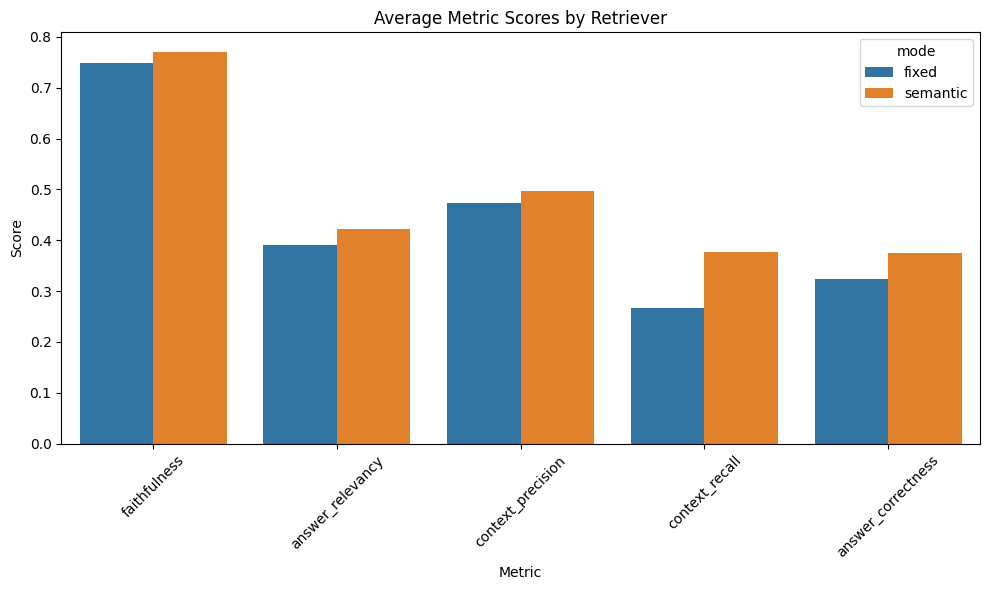

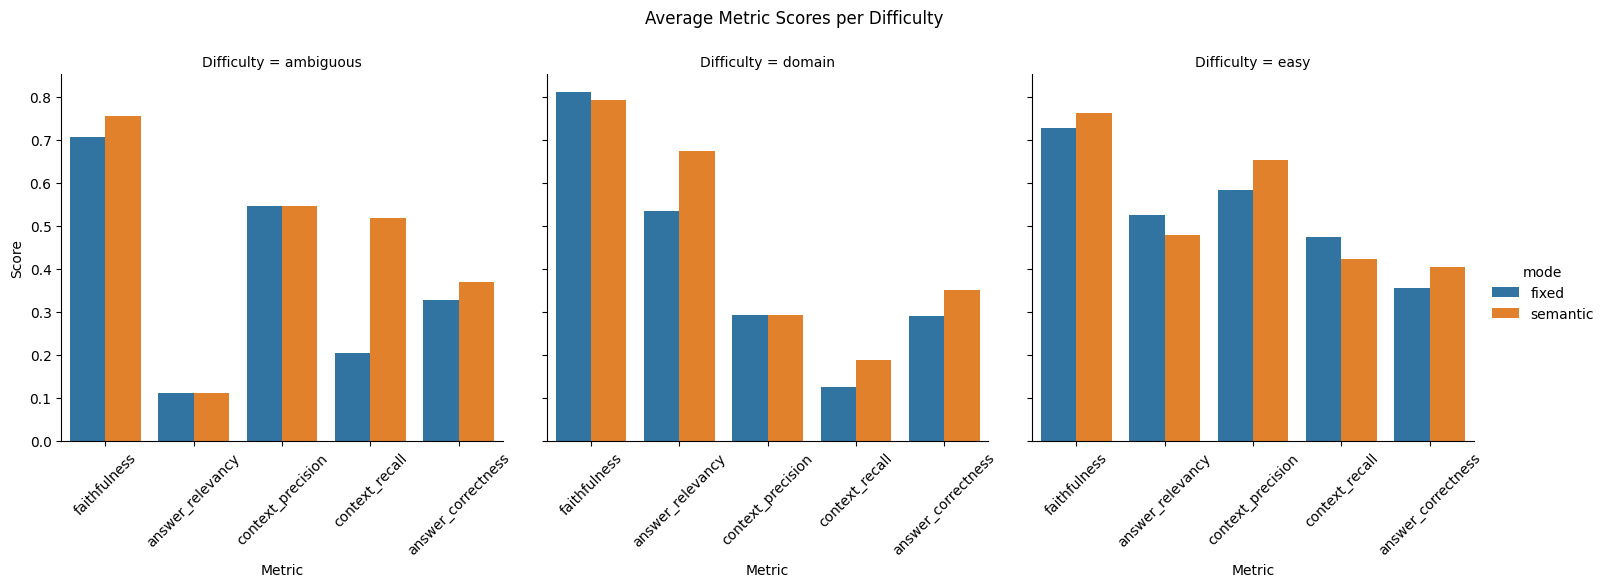

In [ ]:
# Duplicate the grouped evaluation DataFrame to isolate initial answers (no refinement applied)
df_initial = df_grouped.copy()

# Compute average metric scores across all difficulty levels for each retrieval mode
avg_global_initial = df_initial.groupby("mode")[
    ["faithfulness", "answer_relevancy", "context_precision", "context_recall", "answer_correctness"]
].mean().reset_index()

# Compute average metric scores per difficulty level for each retrieval mode
avg_difficulty_initial = df_initial.groupby(["mode", "difficulty"])[
    ["faithfulness", "answer_relevancy", "context_precision", "context_recall", "answer_correctness"]
].mean().reset_index()

# --------------------------------------------------------
# Global comparison: barplot of average scores by retriever (semantic vs fixed)
# --------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_global_initial.melt(id_vars="mode"),
    x="variable", y="value", hue="mode"
)
plt.title("Average RAGAS Metric Scores by Retrieval Strategy")
plt.ylabel("Average Score")
plt.xlabel("Evaluation Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Per-difficulty comparison: barplot faceted by difficulty level
# --------------------------------------------------------
g = sns.catplot(
    data=avg_difficulty_initial.melt(id_vars=["mode", "difficulty"]),
    x="variable", y="value", hue="mode", col="difficulty",
    kind="bar", height=5, aspect=1
)
g.set_titles("Difficulty = {col_name}")
g.set_axis_labels("Evaluation Metric", "Average Score")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Average RAGAS Scores per Difficulty Level and Retrieval Mode")
plt.show()


Semantic chunking is good for retrieval and generated answer performance, outperforming fixed chunks, especially in context recall and answer correctness.

- Semantic chunking on Domain-specific queries shows the most significant improvement, especially in answer relevancy, while easy questions benefit less due to their straightforward nature.

- **Ambiguous queries** show notable gains in **context recall**, indicating semantic chunking better retrieved all necessary information, and indeed, from the answer relevancy is still low because it still needs multi-interpretation

This supports using semantic chunking for complex clinical questions in the RAG system. On the one hand, there needs to be further improvement in terms of query and ground truth creation by collaborating with clinical experts, better computational and financial resources and using more powerful llm such as ChatGPT o3 for better-generated answers